In [1]:
## new models with new data pre-processing
### binary prediction : (user features) -> Pr(response)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cPickle as pickle
import numpy as np
import pandas as pd
import os

import sys
sys.path.append('../../')
from target_pred import FCModel, RNNModel, XGBoostModel, create_sets, evaluate
from target_pred import prepare_trns, report_softmax
import cPickle as pickle
import numpy as np
import pandas as pd
import os

import sklearn
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import cross_validation, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

from random import sample

from scipy import interp

from collections import Counter, defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image
from IPython.display import Image

import xgboost as xgb_lib
from io import BytesIO

import re

import warnings
warnings.filterwarnings("ignore")

/home/drsleep/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def plot_PR_curve(classifier, X, y, n_folds=5):
    """
    Plot a basic precision/recall curve.
    """
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_[:, 1],
                                                               pos_label=1)
        plt.plot(recall, precision, lw=1, label='PR fold %d' % (i,))
   #  clf_name = str(type(classifier))
   # clf_name = clf_name[clf_name.rindex('.')+1:]
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
from string import letters
import seaborn as sns

def corr_matrix(d, figsize = (15, 15)):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                square=True, #xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Binary Model: (response / no response)

### All Data

In [5]:
file_path = '../../../../../../../Documents/projects/new_data/BB/CD_ALL_2017-07-06.csv'
df_usual = pd.read_csv(file_path, sep='>', nrows=10)

In [9]:
df_usual.columns.tolist()

['CLIENT_ID',
 'CONTRACT_REF',
 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
 'TOTAL_BAL_NEG_CHNG_MAX_180',
 'TOTAL_BAL_NEG_CHNG_MAX_31',
 'TOTAL_BAL_NEG_CHNG_MAX_7',
 'TOTAL_BAL_NEG_CHNG_MAX_90',
 'TOTAL_BAL_NEG_CHNG_MIN_180',
 'TOTAL_BAL_NEG_CHNG_MIN_31',
 'TOTAL_BAL_NEG_CHNG_MIN_7',
 'TOTAL_BAL_NEG_CHNG_MIN_90',
 'TOTAL_BAL_NEG_CHNG_N_180',
 'TOTAL_BAL_NEG_CHNG_N_31',
 'TOTAL_BAL_NEG_CHNG_N_7',
 'TOTAL_BAL_NEG_CHNG_N_90',
 'TOTAL_BAL_NEG_CHNG_SUM_180',
 'TOTAL_BAL_NEG_CHNG_SUM_31',
 'TOTAL_BAL_NEG_CHNG_SUM_7',
 'TOTAL_BAL_NEG_CHNG_SUM_90',
 'TOTAL_BAL_POS_CHNG_MAX_180',
 'TOTAL_BAL_POS_CHNG_MAX_31',
 'TOTAL_BAL_POS_CHNG_MAX_7',
 'TOTAL_BAL_POS_CHNG_MAX_90',
 'TOTAL_BAL_POS_CHNG_MIN_180',
 'TOTAL_BAL_POS_CHNG_MIN_31',
 'TOTAL_BAL_POS_CHNG_MIN_7',
 'TOTAL_BAL_POS_CHNG_MIN_90',
 'TOTAL_BAL_POS_CHNG_N_180',
 'TOTAL_BAL_POS_CHNG_N_31',
 'TOTAL_BAL_POS_CHNG_N_7',
 'TOTAL_BAL_POS_CHNG_N_90',
 'TOTAL_BAL_POS_CHNG_SUM_180',
 'TOTAL_BAL_POS_CHNG_SUM_31',
 'TOTA

In [117]:
ignore_cols = [
 'CLIENT_ID',
 'CONTRACT_REF',
# 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
#  'IS_LOYALTY_AUTO',
#  'IS_LOYALTY_BEAUTY',
#  'IS_LOYALTY_ONLINE',
#  'IS_LOYALTY_TRAVEL',
#  'IS_LOYALTY_WEEKEND',
  ]

drop_cols = [ 
 'CLIENT_ID',
 'CONTRACT_REF',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = False
seed = 42
test_size = 0.15

In [118]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=file_path,
                                      sep='>',
                                      ignore_cols_dummy=ignore_cols,
                                      ignore_cols_norm=ignore_cols + ['CONTROL_GROUP_FLG'],
                                      drop_cols=drop_cols,
                                      dummy_config=dummy_config,
                                      fill_na=fill_na,
                                      scaler=scaler,
                                      transform_dict=None,
                                      normalise_dict=None,
                                      test_size=test_size,
                                      seed=seed,
                                      verbose=False)

In [24]:
from blagging import BlaggingClassifier

In [25]:
all_X = pd.concat([Xy_train, Xy_test], axis=0).drop('label', axis=1)
all_y = pd.concat([Xy_train, Xy_test])['label']

In [26]:
clf = DecisionTreeClassifier(min_samples_leaf=10)
predicted = cross_validation.cross_val_predict(clf, all_X, all_y, cv=5)
metrics.accuracy_score(all_y, predicted)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [33]:
metrics.f1_score(all_y, predicted, pos_label=1)

0.18092705167173248

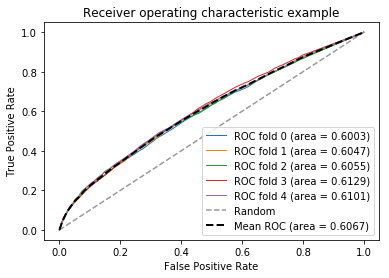

In [34]:
plot_ROC_curve(DecisionTreeClassifier(min_samples_leaf=10), 
               X=all_X.values, y=all_y.values)

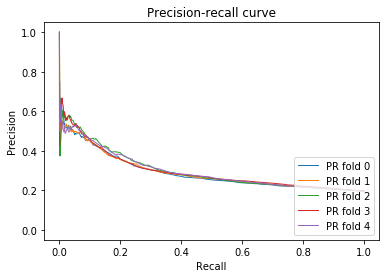

In [35]:
plot_PR_curve(DecisionTreeClassifier(min_samples_leaf=10), 
               X=all_X.values, y=all_y.values)

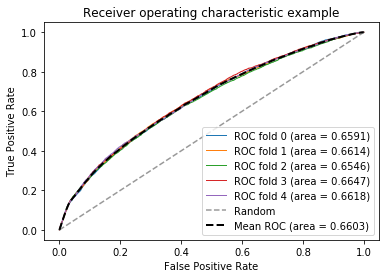

In [36]:
plot_ROC_curve(LogisticRegression(), 
               X=all_X.values, y=all_y.values)

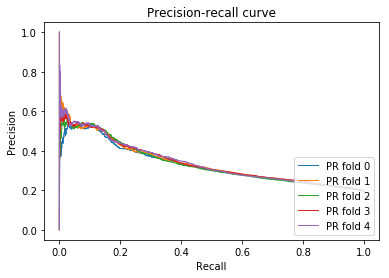

In [37]:
plot_PR_curve(LogisticRegression(), 
               X=all_X.values, y=all_y.values)

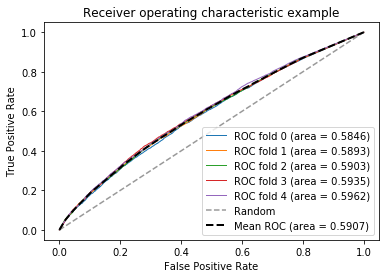

In [38]:
plot_ROC_curve(RandomForestClassifier(n_estimators=50), 
               X=all_X.values, y=all_y.values)

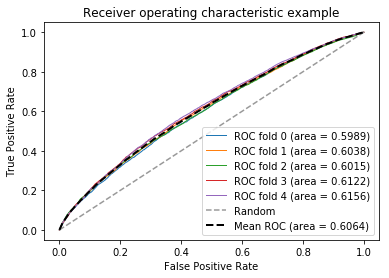

In [39]:
plot_ROC_curve(BlaggingClassifier(n_estimators=50), 
               X=all_X.values, y=all_y.values)

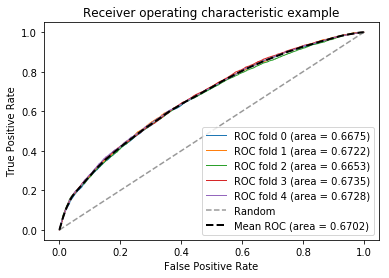

In [40]:
plot_ROC_curve(GradientBoostingClassifier(), 
               X=all_X.values, y=all_y.values)

In [56]:
c_config = dict(max_depth=5, learning_rate=.075, n_estimators=40, seed=seed,
                                 reg_lambda=450, scale_pos_weight=1.15, nthread=4, missing=np.nan,
                                 reg_alpha=200, subsample=0.6)

In [57]:
## generate train/test report of the trained model
c_model = XGBoostModel(c_config)
c_model.train(Xy_train[['BAL', 'label']].drop('label', axis=1), Xy_train.label)
evaluate([c_model.test(Xy_test[['BAL', 'label']].drop('label', axis=1))], Xy_test.label, './BB', file_prefix='test', model_names=['xgb_c'])
evaluate([c_model.test(Xy_train[['BAL', 'label']].drop('label', axis=1))], Xy_train.label, './BB', file_prefix='train', model_names=['xgb_c'])

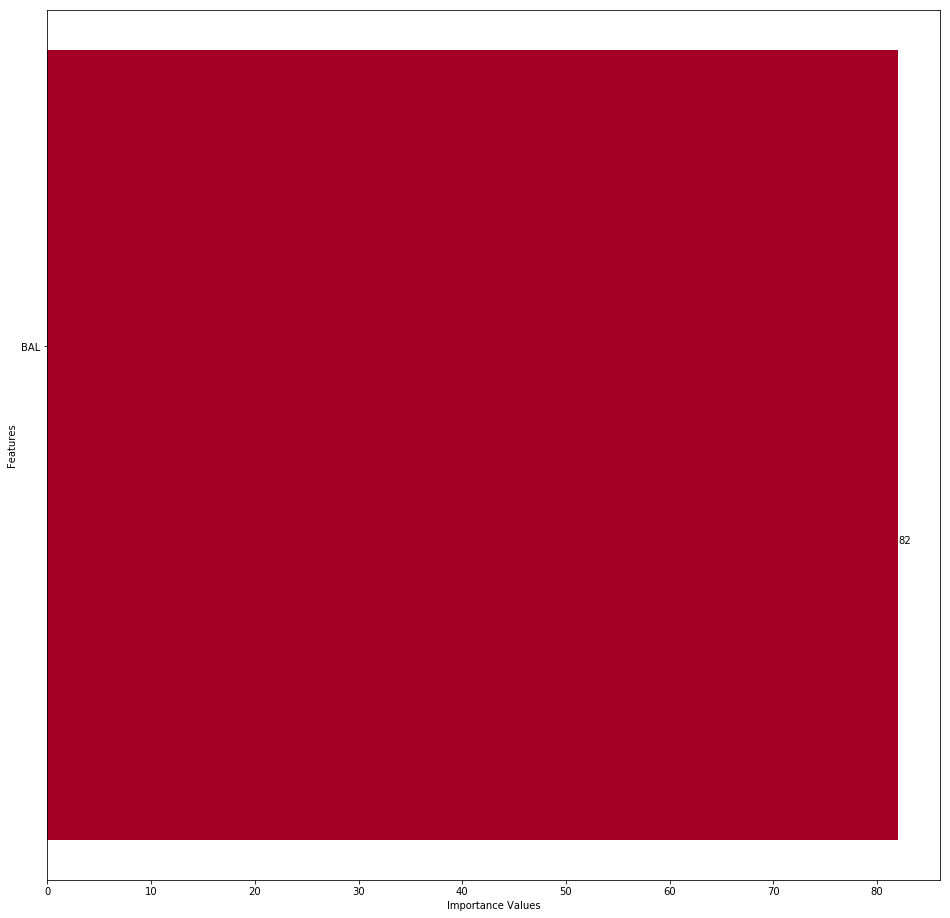

In [58]:
importances = c_model.xgb.booster().get_fscore()
f_names, f_values = zip(*sorted(importances.items(), key=lambda x: x[1]))

st_idx = len(f_names) / 2; end_idx = len(f_names) / 1;

fig = plt.figure(figsize=(16, 16))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')
for i, v in enumerate(f_values[st_idx : end_idx]):
    fig.axes[0].text(v + .02, i - 0.1, v)
plt.show()

## Forward Selection

In [60]:
pool_cols = Xy_train.columns.tolist()

In [61]:
pool_cols.remove("label")

In [62]:
results = dict()
chosen_cols = []
best_fscore = 0.0
while True:
    best_col = None
    for c in pool_cols:
        c_model = XGBoostModel(c_config)
        c_model.train(Xy_train[chosen_cols + [c]], Xy_train.label)
        preds = c_model.test(Xy_test[chosen_cols + [c]])
        c_fscore = f1_score(Xy_test.label, preds.argmax(axis=1))
        if c_fscore > best_fscore:
            best_fscore = c_fscore
            r_score = recall_score(Xy_test.label, preds.argmax(axis=1))
            p_score = precision_score(Xy_test.label, preds.argmax(axis=1))
            best_col = c
    if best_col is not None:
        print("Adding column : {}, f-score : {}".format(best_col, best_fscore))
        chosen_cols.append(best_col)
        results[tuple(chosen_cols)] = [best_fscore, r_score, p_score]
        pool_cols.remove(best_col)
    else:
        break        

Adding column : TOTAL_BAL_NEG_CHNG_SUM_31, f-score : 0.803080308031
Adding column : TOTAL_BAL_POS_CHNG_N_31, f-score : 0.812227074236
Adding column : BAL, f-score : 0.813287514318
Adding column : TOTAL_BAL_NEG_CHNG_N_90, f-score : 0.823801270942
Adding column : TOTAL_BAL_POS_CHNG_MAX_180, f-score : 0.82790165809
Adding column : TXN_TP_POS_MEAN_90, f-score : 0.829971181556


## Forward Selection

In [127]:
pool_cols = Xy_train.columns.tolist()

pool_cols.remove("label")

results = dict()

## train on all columns
c_model = XGBoostModel(c_config)
c_model.train(Xy_train[pool_cols], Xy_train.label)
preds = c_model.test(Xy_test[pool_cols])
best_fscore = f1_score(Xy_test.label, preds.argmax(axis=1))

print("All columns, f-score : {}".format(best_fscore))

while True:
    worst_col = None
    for c in pool_cols:
        cols_to_train = [c_ for c_ in pool_cols if c_ != c]
        c_model = XGBoostModel(c_config)
        c_model.train(Xy_train[cols_to_train], Xy_train.label)
        preds = c_model.test(Xy_test[cols_to_train])
        c_fscore = f1_score(Xy_test.label, preds.argmax(axis=1))
        if c_fscore > best_fscore:
            best_fscore = c_fscore
            r_score = recall_score(Xy_test.label, preds.argmax(axis=1))
            p_score = precision_score(Xy_test.label, preds.argmax(axis=1))
            worst_col = c
    if worst_col is not None:
        print("Deleting column : {}, f-score : {}".format(worst_col, best_fscore))
        results[tuple(chosen_cols)] = [best_fscore, r_score, p_score]
        pool_cols.remove(worst_col)      
    else:
        break        

All columns, f-score : 0.830362277171


## Feature Transformations

In [154]:
from scipy import stats
from collections import Counter, defaultdict
from tqdm import tqdm

In [132]:
c_config = dict(max_depth=5, learning_rate=.075, n_estimators=40, seed=seed,
                                 reg_lambda=450, scale_pos_weight=1., nthread=4, missing=np.nan,
                                 reg_alpha=200, subsample=0.85)

In [141]:
pool_transform = [lambda x: x,
                  lambda x: np.sign(x) * stats.boxcox(np.abs(x) + 1e-8)[0],
                  lambda x: np.sign(x) * np.log(np.abs(x) + 1e-8),
                  np.sinh, np.sqrt, np.arcsinh]

train_preds = []
test_preds = []

for trfm in pool_transform:
    c_model = XGBoostModel(c_config)
    c_model.train(Xy_train.drop('label', axis=1).apply(trfm), Xy_train.label)
    test_preds.append(c_model.test(Xy_test.drop('label', axis=1).apply(trfm)))
    train_preds.append(c_model.test(Xy_train.drop('label', axis=1).apply(trfm)))

In [142]:
model_names = ['None', 'boxcox', 'log', 'sinh', 'sqrt', 'arcsinh']
evaluate(test_preds, Xy_test.label, './BB', file_prefix='test',
         model_names=model_names)
evaluate(train_preds, Xy_train.label, './BB', file_prefix='train',
         model_names=model_names)

In [161]:
## find best transformation for each column
trfm_dict = dict()

pool_transform = [lambda x: x,
                  lambda x: np.sign(x) * stats.boxcox(np.abs(x) + 1e-8)[0],
                  lambda x: np.sign(x) * np.log(np.abs(x) + 1e-8),
                  np.sinh, np.sqrt, np.arcsinh]

cols = Xy_train.drop('label', axis=1).columns
for c in tqdm(cols):
    best_score = -1.0
    for trfm in pool_transform:
        c_model = XGBoostModel(c_config)
        c_model.train(pd.concat([Xy_train[cols].drop(c, axis=1),
                                 Xy_train[[c]].apply(trfm)], axis=1),
                      Xy_train.label)
        preds = c_model.test(pd.concat([Xy_test[cols].drop(c, axis=1),
                                        Xy_test[[c]].apply(trfm)],
                                       axis=1))
        c_fscore = f1_score(Xy_test.label, preds.argmax(axis=1))
        if c_fscore > best_score:
            trfm_dict[c] = trfm
            best_score = c_fscore

100%|██████████| 175/175 [26:49<00:00, 10.60s/it]


In [162]:
Counter(trfm_dict.values())

Counter({<function __main__.<lambda>>: 1,
         <function __main__.<lambda>>: 19,
         <function __main__.<lambda>>: 149,
         <ufunc 'sqrt'>: 6})

In [169]:
def multi_func(functions):
    def f(col):
        return functions[col.name](col)
    return f

Xy_train_trfm = Xy_train.drop('label', axis=1).apply(multi_func(trfm_dict))
Xy_test_trfm = Xy_test.drop('label', axis=1).apply(multi_func(trfm_dict))

In [171]:
c_model = XGBoostModel(c_config)
c_model.train(Xy_train_trfm, Xy_train.label)
test_preds.append(c_model.test(Xy_test_trfm))
train_preds.append(c_model.test(Xy_train_trfm))

In [172]:
model_names = ['None', 'boxcox', 'log', 'sinh', 'sqrt', 'arcsinh', 'sep']
evaluate(test_preds, Xy_test.label, './BB', file_prefix='test',
         model_names=model_names)
evaluate(train_preds, Xy_train.label, './BB', file_prefix='train',
         model_names=model_names)

## Feature importances

In [64]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

In [179]:
ignore_cols = [
 'CLIENT_ID',
 'CONTRACT_REF',
# 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
 'IS_LOYALTY_AUTO',
 'IS_LOYALTY_BEAUTY',
 'IS_LOYALTY_ONLINE',
 'IS_LOYALTY_TRAVEL',
 'IS_LOYALTY_WEEKEND',
  ]

drop_cols = [ 
 'CLIENT_ID',
 'CONTRACT_REF',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = True
seed = 42
test_size = 0.15

In [180]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=file_path,
                                      sep='>',
                                      ignore_cols_dummy=ignore_cols,
                                      ignore_cols_norm=ignore_cols + ['CONTROL_GROUP_FLG'],
                                      drop_cols=drop_cols,
                                      dummy_config=dummy_config,
                                      fill_na=fill_na,
                                      scaler=scaler,
                                      transform_dict=None,
                                      normalise_dict=None,
                                      test_size=test_size,
                                      seed=seed,
                                      verbose=False)

In [68]:
all_X = pd.concat([Xy_train, Xy_test], axis=0).drop('label', axis=1)
all_y = pd.concat([Xy_train, Xy_test])['label']

In [69]:
clf = DecisionTreeClassifier(min_samples_leaf=10)
predicted = cross_validation.cross_val_predict(clf, all_X, all_y, cv=5)
metrics.accuracy_score(all_y, predicted)

0.78795379537953791

In [70]:
metrics.f1_score(all_y, predicted, pos_label=1)

0.78549568765649636

In [72]:
clf = ExtraTreesClassifier()
clf = clf.fit(all_X, all_y)

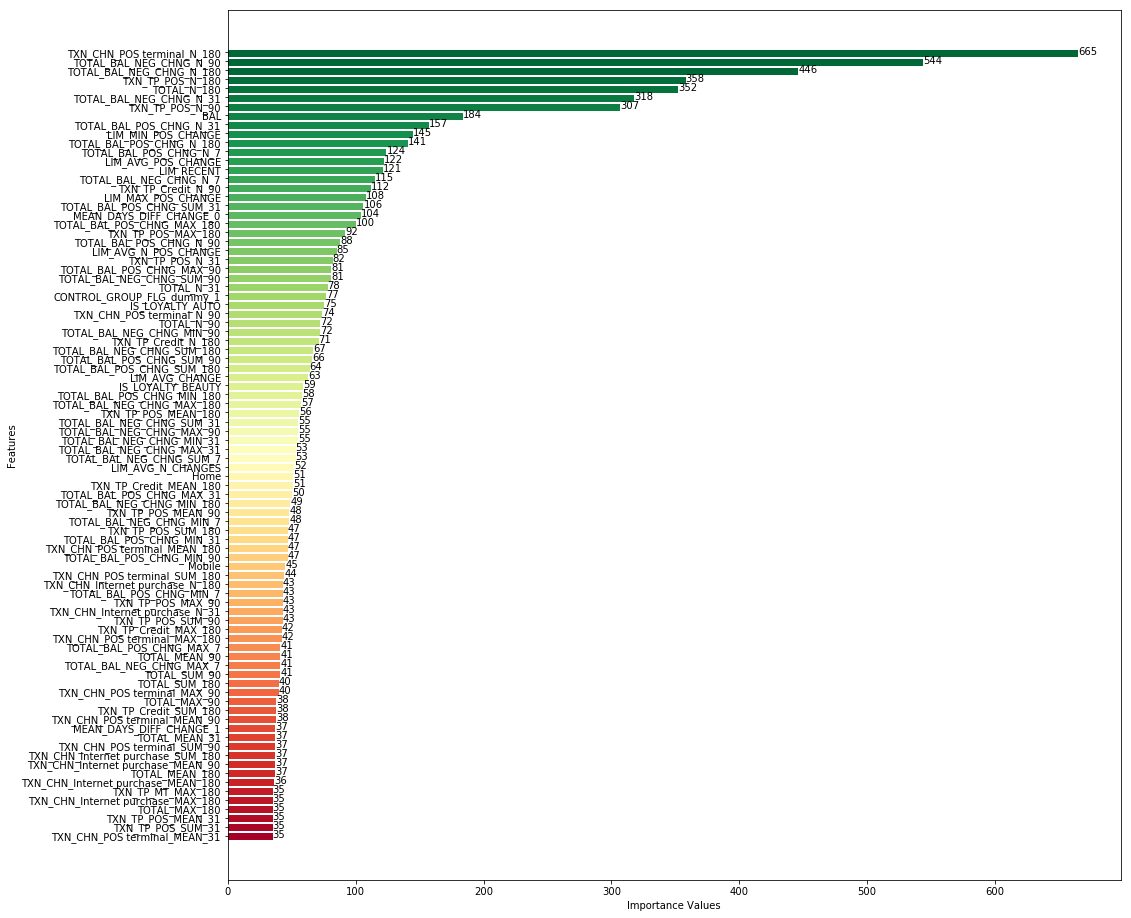

In [81]:
f_names, f_values = all_X.columns, map(lambda x: int(10000 * x), clf.feature_importances_)
f_names = f_names[np.array(f_values).argsort()]
f_values = sorted(f_values)


st_idx = len(f_names) / 2; end_idx = len(f_names) / 1;

fig = plt.figure(figsize=(16, 16))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')
for i, v in enumerate(f_values[st_idx : end_idx]):
    fig.axes[0].text(v + .02, i - 0.1, v)
plt.show()

In [82]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [83]:
clf = LogisticRegression()
rfe = RFE(clf, 20)
rfe = rfe.fit(all_X, all_y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False  True  True False  True  True False False
  True False  True  True False  True False False False False  True False
 False False False False  True False False  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [86]:
print(all_X.columns[rfe.support_])

Index([u'TOTAL_BAL_NEG_CHNG_MIN_31', u'TOTAL_BAL_NEG_CHNG_MIN_7',
       u'TOTAL_BAL_NEG_CHNG_N_180', u'TOTAL_BAL_NEG_CHNG_N_31',
       u'TOTAL_BAL_NEG_CHNG_SUM_180', u'TOTAL_BAL_NEG_CHNG_SUM_7',
       u'TOTAL_BAL_NEG_CHNG_SUM_90', u'TOTAL_BAL_POS_CHNG_MAX_31',
       u'TOTAL_BAL_POS_CHNG_MIN_7', u'TOTAL_BAL_POS_CHNG_SUM_180',
       u'TOTAL_BAL_POS_CHNG_SUM_90', u'BAL', u'IS_LOYALTY_AUTO',
       u'IS_LOYALTY_BEAUTY', u'IS_LOYALTY_ONLINE', u'IS_LOYALTY_TRAVEL',
       u'IS_LOYALTY_WEEKEND', u'TXN_CHN_Internet purchase_MAX_7',
       u'TXN_CHN_Internet purchase_SUM_7', u'CONTROL_GROUP_FLG_dummy_1'],
      dtype='object')


## Correlation Matrix

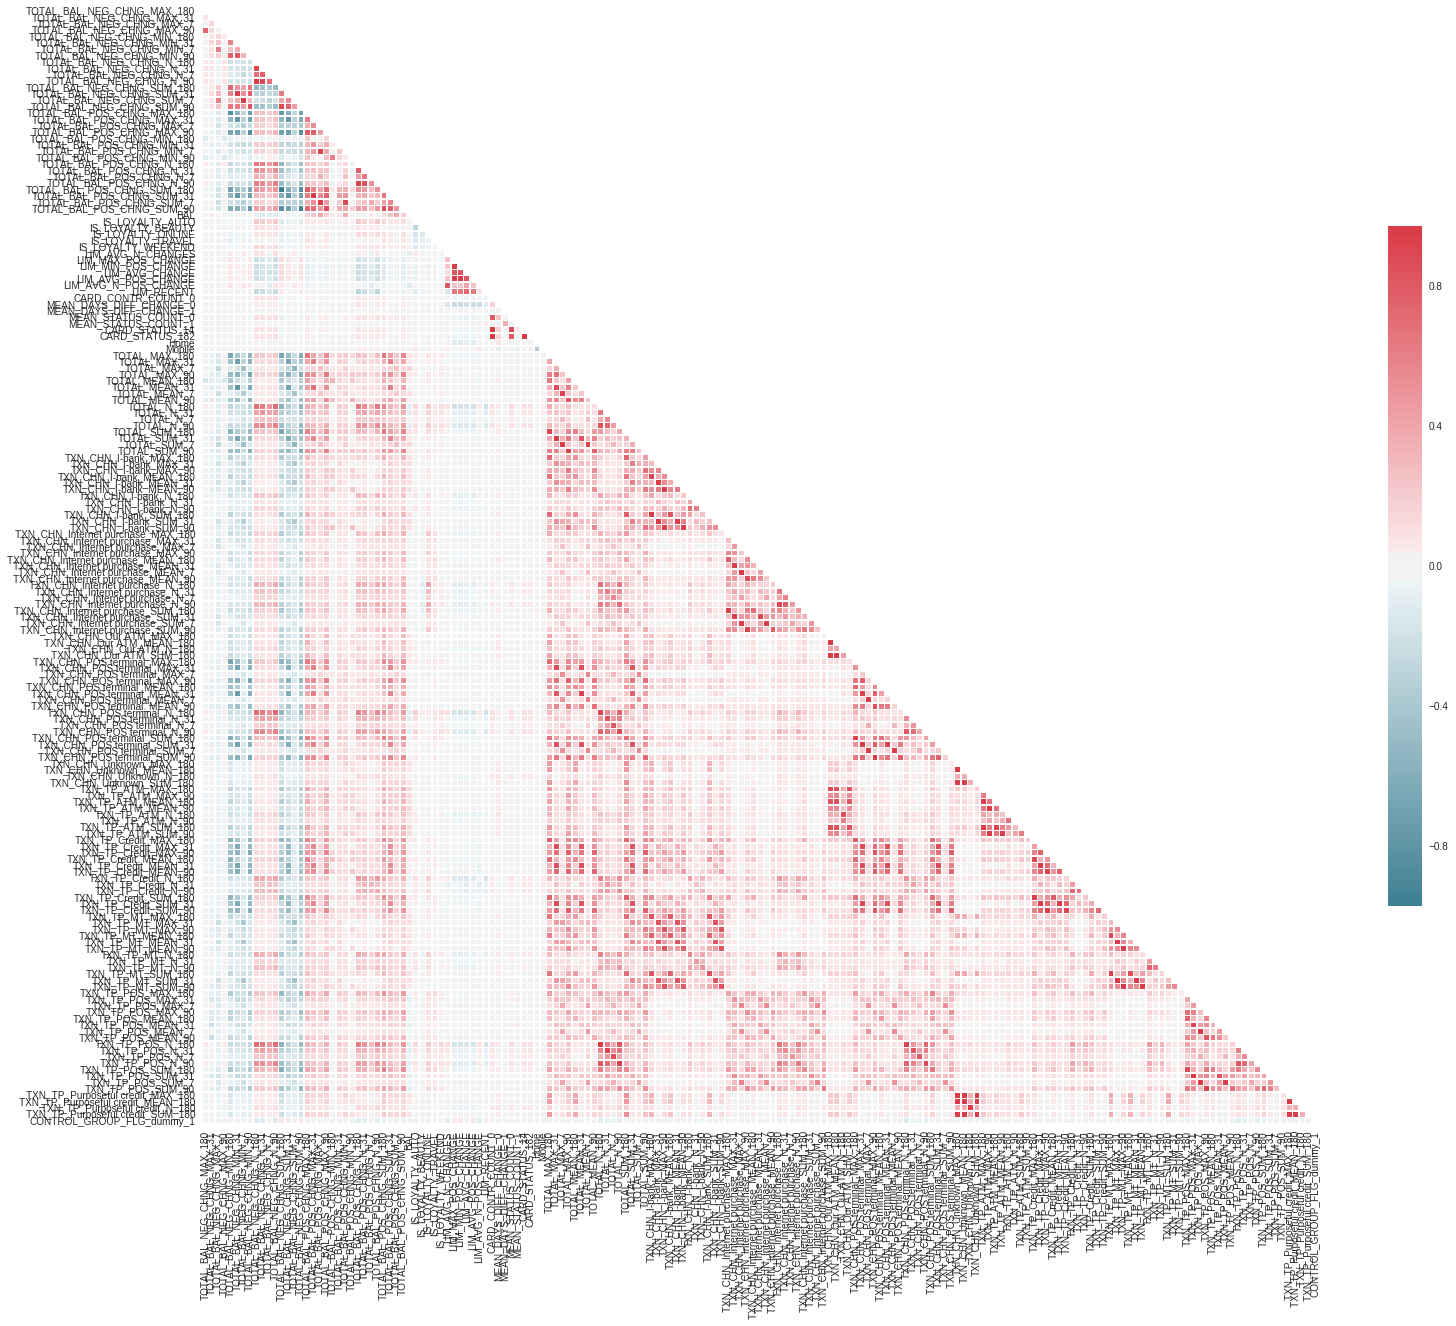

In [94]:
corr_matrix(all_X, figsize=(25, 25))

## PCA

In [95]:
from sklearn.decomposition import PCA

In [113]:
no_pca_cols = [
 'IS_LOYALTY_AUTO',
 'IS_LOYALTY_BEAUTY',
 'IS_LOYALTY_ONLINE',
 'IS_LOYALTY_TRAVEL',
 'IS_LOYALTY_WEEKEND'
]
pca = PCA(n_components=0.99, whiten=True)
X_no_pca = all_X[no_pca_cols]
X_pca = pca.fit_transform(all_X.drop(no_pca_cols, axis=1))

all_X_pca = np.concatenate([X_no_pca.values, X_pca], axis=1)

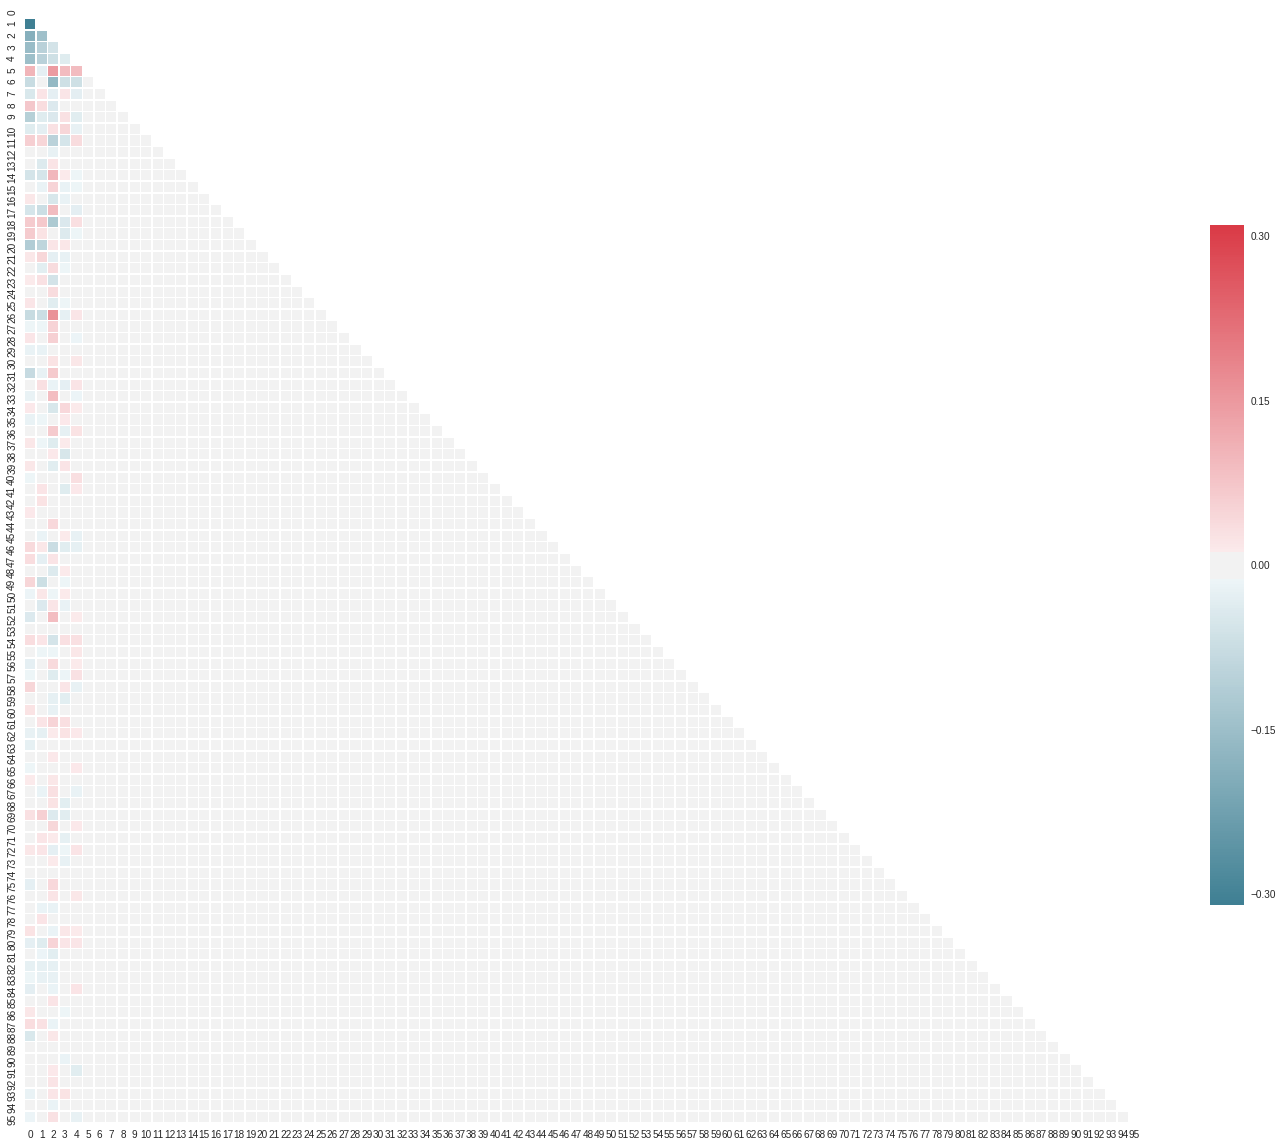

In [114]:
corr_matrix(pd.DataFrame(all_X_pca), figsize=(25, 25))

In [116]:
c_config = dict(max_depth=9, learning_rate=.075, n_estimators=140, seed=seed,
                                 reg_lambda=950, scale_pos_weight=1.15, nthread=4, missing=np.nan,
                                 reg_alpha=200, subsample=0.6)

## generate train/test report of the trained model
c_model = XGBoostModel(c_config)
c_model.train(all_X_pca, all_y)
#evaluate([c_model.test(Xy_test[['BAL', 'label']].drop('label', axis=1))], Xy_test.label, './BB', file_prefix='test', model_names=['xgb_c'])
evaluate([c_model.test(all_X_pca)], all_y, './BB', file_prefix='train', model_names=['xgb_c'])

## SVM

In [186]:
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [187]:
f1_scorer = make_scorer(f1_score)

In [188]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear', 'rbf']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}
    grid_search = GridSearchCV(svm.SVC(), param_grid, scoring=f1_scorer, cv=nfolds, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [189]:
svc_param_selection(Xy_train.drop('label', axis=1), Xy_train.label, 5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] kernel=linear, C=0.001, gamma=0.001 .............................
[CV]  kernel=linear, C=0.001, gamma=0.001, score=0.812567, total=   9.8s
[CV] kernel=linear, C=0.001, gamma=0.001 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


[CV]  kernel=linear, C=0.001, gamma=0.001, score=0.823834, total=   9.7s
[CV] kernel=linear, C=0.001, gamma=0.001 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s


[CV]  kernel=linear, C=0.001, gamma=0.001, score=0.827804, total=  10.3s
[CV] kernel=linear, C=0.001, gamma=0.001 .............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.0s remaining:    0.0s


[CV]  kernel=linear, C=0.001, gamma=0.001, score=0.814196, total=   9.7s
[CV] kernel=linear, C=0.001, gamma=0.001 .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV]  kernel=linear, C=0.001, gamma=0.001, score=0.811685, total=   9.9s
[CV] kernel=rbf, C=0.001, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] . kernel=rbf, C=0.001, gamma=0.001, score=0.668820, total=  23.4s
[CV] kernel=rbf, C=0.001, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s


[CV] . kernel=rbf, C=0.001, gamma=0.001, score=0.668820, total=  20.7s
[CV] kernel=rbf, C=0.001, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV] . kernel=rbf, C=0.001, gamma=0.001, score=0.668582, total=  21.6s
[CV] kernel=rbf, C=0.001, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.1min remaining:    0.0s


[CV] . kernel=rbf, C=0.001, gamma=0.001, score=0.668582, total=  21.1s
[CV] kernel=rbf, C=0.001, gamma=0.001 ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.7min remaining:    0.0s


[CV] . kernel=rbf, C=0.001, gamma=0.001, score=0.668822, total=  21.0s
[CV] kernel=linear, C=0.001, gamma=0.01 ..............................
[CV]  kernel=linear, C=0.001, gamma=0.01, score=0.812567, total=   9.0s
[CV] kernel=linear, C=0.001, gamma=0.01 ..............................
[CV]  kernel=linear, C=0.001, gamma=0.01, score=0.823834, total=   9.4s
[CV] kernel=linear, C=0.001, gamma=0.01 ..............................
[CV]  kernel=linear, C=0.001, gamma=0.01, score=0.827804, total=   9.2s
[CV] kernel=linear, C=0.001, gamma=0.01 ..............................
[CV]  kernel=linear, C=0.001, gamma=0.01, score=0.814196, total=  10.2s
[CV] kernel=linear, C=0.001, gamma=0.01 ..............................
[CV]  kernel=linear, C=0.001, gamma=0.01, score=0.811685, total=   9.9s
[CV] kernel=rbf, C=0.001, gamma=0.01 .................................
[CV] .. kernel=rbf, C=0.001, gamma=0.01, score=0.780148, total=  23.5s
[CV] kernel=rbf, C=0.001, gamma=0.01 .................................
[

[CV] .... kernel=rbf, C=0.01, gamma=0.1, score=0.770265, total=  18.4s
[CV] kernel=rbf, C=0.01, gamma=0.1 ...................................
[CV] .... kernel=rbf, C=0.01, gamma=0.1, score=0.759197, total=  17.8s
[CV] kernel=rbf, C=0.01, gamma=0.1 ...................................
[CV] .... kernel=rbf, C=0.01, gamma=0.1, score=0.766190, total=  17.8s
[CV] kernel=linear, C=0.01, gamma=1 ..................................
[CV] ... kernel=linear, C=0.01, gamma=1, score=0.816871, total=   8.3s
[CV] kernel=linear, C=0.01, gamma=1 ..................................
[CV] ... kernel=linear, C=0.01, gamma=1, score=0.828557, total=   8.6s
[CV] kernel=linear, C=0.01, gamma=1 ..................................
[CV] ... kernel=linear, C=0.01, gamma=1, score=0.828961, total=   9.7s
[CV] kernel=linear, C=0.01, gamma=1 ..................................
[CV] ... kernel=linear, C=0.01, gamma=1, score=0.807773, total=   9.6s
[CV] kernel=linear, C=0.01, gamma=1 ..................................
[CV] .

[CV] ..... kernel=rbf, C=1, gamma=0.001, score=0.820459, total=  12.3s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..... kernel=rbf, C=1, gamma=0.001, score=0.829169, total=  11.9s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..... kernel=rbf, C=1, gamma=0.001, score=0.826694, total=  11.9s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..... kernel=rbf, C=1, gamma=0.001, score=0.810922, total=  11.8s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..... kernel=rbf, C=1, gamma=0.001, score=0.821792, total=  11.7s
[CV] kernel=linear, C=1, gamma=0.01 ..................................
[CV] ... kernel=linear, C=1, gamma=0.01, score=0.819690, total=  26.2s
[CV] kernel=linear, C=1, gamma=0.01 ..................................
[CV] ... kernel=linear, C=1, gamma=0.01, score=0.822105, total=  22.2s
[CV] kernel=linear, C=1, gamma=0.01 ..................................
[CV] .

[CV] ... kernel=linear, C=10, gamma=0.1, score=0.808488, total= 3.1min
[CV] kernel=linear, C=10, gamma=0.1 ..................................
[CV] ... kernel=linear, C=10, gamma=0.1, score=0.827187, total= 2.9min
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ...... kernel=rbf, C=10, gamma=0.1, score=0.807891, total=  53.4s
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ...... kernel=rbf, C=10, gamma=0.1, score=0.803379, total=  33.9s
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ...... kernel=rbf, C=10, gamma=0.1, score=0.808071, total=  21.7s
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ...... kernel=rbf, C=10, gamma=0.1, score=0.782892, total=  21.8s
[CV] kernel=rbf, C=10, gamma=0.1 .....................................
[CV] ...... kernel=rbf, C=10, gamma=0.1, score=0.793785, total=  21.6s
[CV] kernel=linear, C=10, gamma=1 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 121.5min finished


{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [193]:
clf = svm.SVC(C=10, gamma=0.001, kernel='rbf', probability=True)
clf.fit(Xy_train.drop('label', axis=1), Xy_train.label)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [196]:
test_preds.append(clf.predict_proba(Xy_test.drop('label', axis=1)))
train_preds.append(clf.predict_proba(Xy_train.drop('label', axis=1)))

In [198]:
evaluate([clf.predict_proba(Xy_test.drop('label', axis=1))], 
         Xy_test.label, './BB', file_prefix='test', 
         model_names=['svc'])
evaluate([clf.predict_proba(Xy_train.drop('label', axis=1))], 
         Xy_train.label, './BB', file_prefix='train', 
         model_names=['svc'])

## Multi-class

In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [5]:
file_path = '../../../../../../../Documents/projects/new_data/BB/CD_ALL_2017-07-06.csv'
df_usual = pd.read_csv(file_path, sep='>', nrows=10)

In [8]:
ignore_cols = [
 'CLIENT_ID',
 'CONTRACT_REF',
# 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
#  'IS_LOYALTY_AUTO',
#  'IS_LOYALTY_BEAUTY',
#  'IS_LOYALTY_ONLINE',
#  'IS_LOYALTY_TRAVEL',
#  'IS_LOYALTY_WEEKEND',
  ]

drop_cols = [ 
 'CLIENT_ID',
 'CONTRACT_REF',
 'BANK',
# 'SCENARIO_NAME_UNI',
 'START_DATE',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = False
seed = 42
test_size = 0.15

In [9]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=file_path,
                                      sep='>',
                                      ignore_cols_dummy=ignore_cols + ['IS_LOYALTY_AUTO',
                                                                       'IS_LOYALTY_BEAUTY',
                                                                       'IS_LOYALTY_ONLINE',
                                                                       'IS_LOYALTY_TRAVEL',
                                                                       'IS_LOYALTY_WEEKEND'],
                                      ignore_cols_norm=ignore_cols + ['CONTROL_GROUP_FLG'],
                                      drop_cols=drop_cols,
                                      dummy_config=dummy_config,
                                      fill_na=fill_na,
                                      scaler=scaler,
                                      transform_dict=None,
                                      normalise_dict=None,
                                      test_size=test_size,
                                      seed=seed,
                                      verbose=False)

In [12]:
## only on those who responded
Xy_train = Xy_train[Xy_train.label == 1]#.dropna()
Xy_test = Xy_test[Xy_test.label == 1]#.dropna()

In [13]:
Counter(Xy_train.SCENARIO_NAME_UNI)

Counter({u'POS_1': 2532,
         u'POS_2': 32,
         u'POS_3': 40,
         u'UVEL_1': 921,
         u'UVEL_3': 32,
         u'UVEL_4': 971,
         u'UVEL_5': 116,
         u'UVEL_6': 13})

In [14]:
Counter(Xy_test.SCENARIO_NAME_UNI)

Counter({u'POS_1': 459,
         u'POS_2': 1,
         u'POS_3': 8,
         u'UVEL_1': 180,
         u'UVEL_3': 8,
         u'UVEL_4': 149,
         u'UVEL_5': 14,
         u'UVEL_6': 3})

In [20]:
lbl_enc = LabelEncoder()
lbl_enc.fit(Xy_train.SCENARIO_NAME_UNI)

LabelEncoder()

In [26]:
Xy_train.label = lbl_enc.transform(Xy_train.SCENARIO_NAME_UNI)
Xy_test.label = lbl_enc.transform(Xy_test.SCENARIO_NAME_UNI)

In [29]:
max_scenario = Xy_train.label.max()

In [27]:
drop_cols_model = ['label', 'SCENARIO_NAME_UNI']

In [52]:
w_scale = 1000. # 80
w_bias = 19. # 84
w_dict = dict([(x, max(w_bias - w_scale * y / len(Xy_train), 1) ) for x, y in zip(l_vals, l_counts)])

In [53]:
w_dict

{0: 1,
 1: 12.12862357741035,
 2: 10.410779471762938,
 3: 1,
 4: 12.12862357741035,
 5: 1,
 6: 1,
 7: 16.208503328322955}

In [77]:
def mean_scores(y_true, y_pred, n_classes):
    """Return (mean_acc, mean_precision, mean_recall, mean_fscore) throughout all classes.
       The script computes per-class scores and returns the averages.
    """
    accs = []; precs = []; recs = []; fscores = []
    for i in range(n_classes):
        ## replace non-i classes with one common value: e.g. (i - 1)
        y_true_i = np.copy(y_true)
        y_true_i[y_true_i != i] = i - 1
        y_pred_i = np.copy(y_pred)
        y_pred_i[y_pred_i != i] = i - 1
        
        accs.append(accuracy_score(y_true_i, y_pred_i))
        precs.append(precision_score(y_true_i, y_pred_i, pos_label=i))
        recs.append(recall_score(y_true_i, y_pred_i, pos_label=i))
        fscores.append(f1_score(y_true_i, y_pred_i, pos_label=i))
    return (np.mean(accs), np.mean(precs), 
            np.mean(recs), np.mean(fscores))

In [108]:
Xy_trn, Xy_dev = train_test_split(Xy_train, test_size=0.15, 
                                  stratify=Xy_train.label, random_state=seed)

In [122]:
### weighting by empirical counts
l_vals, l_counts = np.unique(Xy_trn['label'], return_counts=True)

N_trials = 150

params_dict = dict()
best_f_score = -1.0

for i in tqdm(range(N_trials)):
    #w_param = 19. ### weighting parameter : can be replaced with two parameters (scale, bias)
    #w_scale = 100. # 80
    #w_bias = 14. # 84
    w_scale = np.random.uniform(low=300, high=900)
    ##
    scale_to_bias = np.random.uniform(low=1.25, high=1.6)
    max_depth = np.random.randint(low=3, high=12)
    eta = np.random.uniform(low=1e-5, high=1e-1)
    reg_lambda = np.random.uniform(low=10, high=2000)
    reg_alpha = np.random.uniform(low=10, high=2000)
    subsample = np.random.uniform(low=0.5, high=0.99)
    max_delta_step = np.random.uniform(low=1.0, high=10.)
    n_estimators = np.random.randint(low=20, high=200)
    
    w_bias = w_scale / scale_to_bias #np.random.uniform(low=1, high=500)
    w_dict = dict([(x, max(w_bias - w_scale * y / len(Xy_trn), 1) ) for x, y in zip(l_vals, l_counts)])
    
    ### another way of weighting
    # w_dict = dict([(x, 10) for x, y in zip(l_vals, l_counts)])
    # w_dict[12] = 1
    # w_dict[3] = 3
    # w_dict[6] = 3

    ### input data
    xg_trn = xgb_lib.DMatrix(Xy_trn.drop(drop_cols_model, axis=1), 
                             label=Xy_trn.label,
                             weight=[w_dict[y] for y in Xy_trn.label]
                            )
    xg_tst = xgb_lib.DMatrix(Xy_dev.drop(drop_cols_model, axis=1), 
                             label=Xy_dev.label)

    c_config2 = dict(max_depth=max_depth, 
                     eta=eta, 
                     n_estimators=n_estimators, 
                     seed=seed,
                     reg_lambda=reg_lambda,
                     nthread=4, missing=np.nan,
                     alpha=reg_alpha, 
                     subsample=subsample, 
                     objective="multi:softprob",
                     num_class=max_scenario + 1,
                     max_delta_step=max_delta_step
                    )
    c_config2['lambda'] = c_config2['reg_lambda']

    bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

    preds_trn = bst.predict(xg_trn)
    preds_tst = bst.predict(xg_tst)
    _, _, _, c_f_score = mean_scores(Xy_dev.label.values, 
                                     preds_tst.argmax(axis=1), 
                                     max_scenario + 1)
    if c_f_score > best_f_score:
        print("New best F1-score : {:.4f}".format(c_f_score))
        best_f_score = c_f_score
        params_dict['max_depth'] = max_depth
        params_dict['w_scale'] = w_scale
        params_dict['w_bias'] = w_bias
        params_dict['eta'] = eta
        params_dict['reg_lambda'] = reg_lambda
        params_dict['reg_alpha'] = reg_alpha
        params_dict['subsample'] = subsample
        params_dict['max_delta_step'] = max_delta_step
        params_dict['n_estimators'] = n_estimators

  1%|          | 1/150 [00:12<30:45, 12.38s/it]

New best F1-score : 0.7230


  1%|▏         | 2/150 [00:27<32:36, 13.22s/it]

New best F1-score : 0.7358


  5%|▍         | 7/150 [01:25<26:42, 11.21s/it]

New best F1-score : 0.7474


  9%|▊         | 13/150 [02:41<29:18, 12.84s/it]

New best F1-score : 0.7489


100%|██████████| 150/150 [29:24<00:00, 10.39s/it]


In [123]:
(best_f_score, params_dict)

(0.7489108998764521,
 {'eta': 0.08989345445872673,
  'max_delta_step': 9.50195601958295,
  'max_depth': 3,
  'n_estimators': 148,
  'reg_alpha': 949.38899639083,
  'reg_lambda': 1214.8177499258622,
  'subsample': 0.5879699909024085,
  'w_bias': 687.5361274931537,
  'w_scale': 896.7048669599018})

In [101]:
(best_f_score, best_w_scale, best_w_bias)

(0.72024262484013313, 303.426326986624, 220.88540234187923)

In [82]:
(best_f_score, best_w_scale, best_w_bias)

(0.70143206742507036, 483.44370645284704, 338.326404532854)

In [124]:
l_vals, l_counts = np.unique(Xy_train['label'], return_counts=True)

w_scale = params_dict['w_scale']#303.426326986624 # 670.3930531787973 #484.44370645284704
w_bias = params_dict['w_bias']#220.88540234187923#505.6740466075829 #338.326404532854
w_dict = dict([(x, max(w_bias - w_scale * y / len(Xy_train), 1) ) for x, y in zip(l_vals, l_counts)])

### another way of weighting
# w_dict = dict([(x, 10) for x, y in zip(l_vals, l_counts)])
# w_dict[12] = 1
# w_dict[3] = 3
# w_dict[6] = 3

### input data
xg_trn = xgb_lib.DMatrix(Xy_train.drop(drop_cols_model, axis=1), 
                         label=Xy_train.label,
                         weight=[w_dict[y] for y in Xy_train.label]
                        )
xg_tst = xgb_lib.DMatrix(Xy_test.drop(drop_cols_model, axis=1), 
                         label=Xy_test.label)

c_config2 = dict(max_depth=params_dict['max_depth'],
                 eta=params_dict['eta'],
                 n_estimators=params_dict['n_estimators'],
                 seed=seed,
                 reg_lambda=params_dict['reg_lambda'], nthread=4, missing=np.nan,
                 alpha=params_dict['reg_alpha'], 
                 subsample=params_dict['subsample'],
                 objective="multi:softprob",
                 num_class=max_scenario + 1,
                 max_delta_step=params_dict['max_delta_step']
                )
c_config2['lambda'] = c_config2['reg_lambda']

bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

preds_trn = bst.predict(xg_trn)
preds_tst = bst.predict(xg_tst)

In [125]:
mean_scores(Xy_test.label.values, preds_tst.argmax(axis=1), max_scenario + 1)

(0.94586374695863751,
 0.67816220641076863,
 0.64212566738104637,
 0.6544120578457151)

In [126]:
## report
acc_df_trn, df_cm_trn = report_softmax(Xy_train.label, 
                                       preds_trn, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(Xy_test.label,
                                       preds_tst,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall precision    fscore
all_labels  0.945673       NaN       NaN  0.783455       NaN       NaN
0           0.992496  0.998411  0.995445  0.986928  0.997797  0.992333
1             0.9375  0.833333  0.882353         0         0       NaN
2              0.975  0.906977  0.939759      0.75  0.857143       0.8
3           0.851249  0.898053  0.874025  0.477778  0.544304  0.508876
4                  1  0.969697  0.984615     0.875  0.777778  0.823529
5           0.906282   0.86529  0.885312   0.52349  0.448276  0.482972
6           0.974138   0.91129  0.941667  0.857143       0.8  0.827586
7                  1  0.928571  0.962963  0.666667         1       0.8
      0   1   2    3   4    5    6   7
0  2513   6   3    2   1    7    0   0
1     1  30   1    0   0    0    0   0
2     1   0  39    0   0    0    0   0
3     1   0   0  784   0  130    6   0
4     0   0   0    0  32    0    0   0
5     1   0   0   85   0  880    5   0
6     0   0   0  

In [86]:
Counter(preds_tst.argmax(axis=1))

Counter({0: 450, 1: 5, 2: 6, 3: 152, 4: 10, 5: 182, 6: 15, 7: 2})

In [87]:
Counter(Xy_test.label)

Counter({0: 459, 1: 1, 2: 8, 3: 180, 4: 8, 5: 149, 6: 14, 7: 3})

## Adaboost

In [127]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [133]:
file_path = '../../../../../../../Documents/projects/new_data/BB/CD_ALL_2017-07-06.csv'
df_usual = pd.read_csv(file_path, sep='>', nrows=10)

In [134]:
ignore_cols = [
 'CLIENT_ID',
 'CONTRACT_REF',
# 'CONTROL_GROUP_FLG',
 'BANK',
 'SCENARIO_NAME_UNI',
 'START_DATE',
 'label',
#  'IS_LOYALTY_AUTO',
#  'IS_LOYALTY_BEAUTY',
#  'IS_LOYALTY_ONLINE',
#  'IS_LOYALTY_TRAVEL',
#  'IS_LOYALTY_WEEKEND',
  ]

drop_cols = [ 
 'CLIENT_ID',
 'CONTRACT_REF',
 'BANK',
# 'SCENARIO_NAME_UNI',
 'START_DATE',
 'LAST_CARD_STATUS_DT',
 'LAST_CONTR_STATUS_DT']

scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = True
seed = 42
test_size = 0.15

In [135]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=file_path,
                                      sep='>',
                                      ignore_cols_dummy=ignore_cols + ['IS_LOYALTY_AUTO',
                                                                       'IS_LOYALTY_BEAUTY',
                                                                       'IS_LOYALTY_ONLINE',
                                                                       'IS_LOYALTY_TRAVEL',
                                                                       'IS_LOYALTY_WEEKEND'],
                                      ignore_cols_norm=ignore_cols + ['CONTROL_GROUP_FLG'],
                                      drop_cols=drop_cols,
                                      dummy_config=dummy_config,
                                      fill_na=fill_na,
                                      scaler=scaler,
                                      transform_dict=None,
                                      normalise_dict=None,
                                      test_size=test_size,
                                      seed=seed,
                                      verbose=False)

In [136]:
## only on those who responded
Xy_train = Xy_train[Xy_train.label == 1]#.dropna()
Xy_test = Xy_test[Xy_test.label == 1]#.dropna()

In [137]:
lbl_enc = LabelEncoder()
lbl_enc.fit(Xy_train.SCENARIO_NAME_UNI)

LabelEncoder()

In [138]:
Xy_train.label = lbl_enc.transform(Xy_train.SCENARIO_NAME_UNI)
Xy_test.label = lbl_enc.transform(Xy_test.SCENARIO_NAME_UNI)

In [139]:
max_scenario = Xy_train.label.max()

In [140]:
drop_cols_model = ['label', 'SCENARIO_NAME_UNI']

In [146]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [ ]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,

In [155]:
def ada_param_selection(X, y, nfolds):
    max_depth = [1, 2, 3, 4, 5, 6, 7]
    lrs = [0.001, 0.01, 0.1, 1]
    n_estimators = [10, 100, 500, 1000]
    param_grid = {#'max_depth': max_depth, 
                  'learning_rate' : lrs,
                  'n_estimators' : n_estimators}
    
    grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=7)),
                               param_grid, scoring=f1_scorer, cv=nfolds, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [156]:
ada_param_selection(Xy_train.drop(drop_cols_model, axis=1), Xy_train.label, 5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] n_estimators=10, learning_rate=0.001 ............................
[CV]  n_estimators=10, learning_rate=0.001, score=0.774364, total=   1.9s
[CV] n_estimators=10, learning_rate=0.001 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  n_estimators=10, learning_rate=0.001, score=0.762491, total=   1.9s
[CV] n_estimators=10, learning_rate=0.001 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=10, learning_rate=0.001, score=0.755133, total=   2.0s
[CV] n_estimators=10, learning_rate=0.001 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s


[CV]  n_estimators=10, learning_rate=0.001, score=0.771054, total=   1.8s
[CV] n_estimators=10, learning_rate=0.001 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s


[CV]  n_estimators=10, learning_rate=0.001, score=0.771799, total=   1.8s
[CV] n_estimators=100, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.001, score=0.781086, total=  17.6s
[CV] n_estimators=100, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   27.3s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.001, score=0.749780, total=  19.2s
[CV] n_estimators=100, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   46.7s remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.001, score=0.775984, total=  17.9s
[CV] n_estimators=100, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.001, score=0.779397, total=  18.1s
[CV] n_estimators=100, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=100, learning_rate=0.001, score=0.778463, total=  17.1s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.775140, total= 1.4min
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.761518, total= 1.5min
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.766187, total= 1.3min
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.774458, total= 1.5min
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.781215, total= 1.4min
[CV] n_estimators=1000, learning_rate=0.001 ..........................
[CV]  n_estimators=1000, learning_rate=0.001, score=0.767890, total= 2.6min
[CV] n_estimators=1000, learning_rate=0.001 ....

[CV]  n_estimators=100, learning_rate=1, score=0.782229, total=  24.1s
[CV] n_estimators=100, learning_rate=1 ...............................
[CV]  n_estimators=100, learning_rate=1, score=0.766006, total=  23.7s
[CV] n_estimators=100, learning_rate=1 ...............................
[CV]  n_estimators=100, learning_rate=1, score=0.764505, total=  24.0s
[CV] n_estimators=100, learning_rate=1 ...............................
[CV]  n_estimators=100, learning_rate=1, score=0.765817, total=  24.1s
[CV] n_estimators=500, learning_rate=1 ...............................
[CV]  n_estimators=500, learning_rate=1, score=0.774895, total= 2.0min
[CV] n_estimators=500, learning_rate=1 ...............................
[CV]  n_estimators=500, learning_rate=1, score=0.779678, total= 2.0min
[CV] n_estimators=500, learning_rate=1 ...............................
[CV]  n_estimators=500, learning_rate=1, score=0.760691, total= 2.0min
[CV] n_estimators=500, learning_rate=1 ...............................
[CV]  

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 116.0min finished


{'learning_rate': 0.1, 'n_estimators': 10}

In [157]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7),
                         learning_rate=0.1, n_estimators=10)
clf.fit(Xy_train.drop(drop_cols_model, axis=1), Xy_train.label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=10, random_state=None)

In [158]:
test_preds = clf.predict_proba(Xy_test.drop(drop_cols_model, axis=1))
train_preds = clf.predict_proba(Xy_train.drop(drop_cols_model, axis=1))

In [159]:
mean_scores(Xy_test.label, test_preds.argmax(axis=1), max_scenario + 1)

(0.94525547445255476,
 0.67620794031520448,
 0.62141644316190314,
 0.64234387907159984)

In [160]:
f1_score(Xy_test.label, test_preds.argmax(axis=1), average='weighted')

0.78307965423180148

In [161]:
## report
acc_df_trn, df_cm_trn = report_softmax(Xy_train.label, 
                                       train_preds, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(Xy_test.label,
                                       test_preds,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall precision    fscore
all_labels  0.896929       NaN       NaN  0.781022       NaN       NaN
0                  1         1         1  0.976035  0.986784   0.98138
1                  1         1         1         0         0       NaN
2                  1         1         1      0.75  0.857143       0.8
3           0.687296  0.767273  0.725086  0.438889  0.556338  0.490683
4                  1         1         1      0.75      0.75      0.75
5           0.802266  0.730084  0.764475  0.604027  0.473684  0.530973
6                  1         1         1  0.785714  0.785714  0.785714
7                  1         1         1  0.666667         1       0.8
      0   1   2    3   4    5    6   7
0  2532   0   0    0   0    0    0   0
1     0  32   0    0   0    0    0   0
2     0   0  40    0   0    0    0   0
3     0   0   0  633   0  288    0   0
4     0   0   0    0  32    0    0   0
5     0   0   0  192   0  779    0   0
6     0   0   0  

In [163]:
Counter(lbl_enc.inverse_transform(Xy_test.label))

Counter({u'POS_1': 459,
         u'POS_2': 1,
         u'POS_3': 8,
         u'UVEL_1': 180,
         u'UVEL_3': 8,
         u'UVEL_4': 149,
         u'UVEL_5': 14,
         u'UVEL_6': 3})

In [166]:
Xy_train.BAL.unique()

array([ 1.49402826, -1.07454281, -0.06634492, ...,  0.09334216,
       -0.21849451,  0.09750899])

## Adding interaction variables

In [168]:
from itertools import combinations

In [210]:
N = 2 # N-way interactions
max_n_cols = 500 # max number of added columns
n_cols = 0
for j in combinations(Xy_train.drop(drop_cols_model, axis=1).columns, N):
    if n_cols >= max_n_cols:
        break
    for f in [np.sum, np.prod]:
        Xy_train['_'.join(list(j) + [f.__name__])] = Xy_train[list(j)].apply(f, axis=1)
        Xy_test['_'.join(list(j) + [f.__name__])] = Xy_test[list(j)].apply(f, axis=1)
    n_cols += 1

In [215]:
l_vals, l_counts = np.unique(Xy_train['label'], return_counts=True)

w_scale = params_dict['w_scale']#303.426326986624 # 670.3930531787973 #484.44370645284704
w_bias = params_dict['w_bias']#220.88540234187923#505.6740466075829 #338.326404532854
w_dict = dict([(x, max(w_bias - w_scale * y / len(Xy_train), 1) ) for x, y in zip(l_vals, l_counts)])

### another way of weighting
# w_dict = dict([(x, 10) for x, y in zip(l_vals, l_counts)])
# w_dict[12] = 1
# w_dict[3] = 3
# w_dict[6] = 3

### input data
xg_trn = xgb_lib.DMatrix(Xy_train.drop(drop_cols_model, axis=1), 
                         label=Xy_train.label,
                         weight=[w_dict[y] for y in Xy_train.label]
                        )
xg_tst = xgb_lib.DMatrix(Xy_test.drop(drop_cols_model, axis=1), 
                         label=Xy_test.label)

c_config2 = dict(max_depth=params_dict['max_depth'],
                 eta=0.005,#params_dict['eta'],
                 n_estimators=params_dict['n_estimators'],
                 seed=seed,
                 reg_lambda=params_dict['reg_lambda'], nthread=4, missing=np.nan,
                 alpha=params_dict['reg_alpha'], 
                 subsample=params_dict['subsample'],
                 objective="multi:softprob",
                 num_class=max_scenario + 1,
                 max_delta_step=params_dict['max_delta_step']
                )
c_config2['lambda'] = c_config2['reg_lambda']

bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

preds_trn = bst.predict(xg_trn)
preds_tst = bst.predict(xg_tst)

In [216]:
mean_scores(Xy_train.label.values, preds_trn.argmax(axis=1), max_scenario + 1)

(0.95538973588146869,
 0.79601105826629437,
 0.80802931231070685,
 0.79501060146876124)

In [217]:
mean_scores(Xy_test.label.values, preds_tst.argmax(axis=1), max_scenario + 1)

(0.93947688564476883,
 0.66220562587750087,
 0.56839429843525768,
 0.58076149443601832)

In [126]:
## report
acc_df_trn, df_cm_trn = report_softmax(Xy_train.label, 
                                       preds_trn, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(Xy_test.label,
                                       preds_tst,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall precision    fscore
all_labels  0.945673       NaN       NaN  0.783455       NaN       NaN
0           0.992496  0.998411  0.995445  0.986928  0.997797  0.992333
1             0.9375  0.833333  0.882353         0         0       NaN
2              0.975  0.906977  0.939759      0.75  0.857143       0.8
3           0.851249  0.898053  0.874025  0.477778  0.544304  0.508876
4                  1  0.969697  0.984615     0.875  0.777778  0.823529
5           0.906282   0.86529  0.885312   0.52349  0.448276  0.482972
6           0.974138   0.91129  0.941667  0.857143       0.8  0.827586
7                  1  0.928571  0.962963  0.666667         1       0.8
      0   1   2    3   4    5    6   7
0  2513   6   3    2   1    7    0   0
1     1  30   1    0   0    0    0   0
2     1   0  39    0   0    0    0   0
3     1   0   0  784   0  130    6   0
4     0   0   0    0  32    0    0   0
5     1   0   0   85   0  880    5   0
6     0   0   0  

In [218]:
zip(*sorted(importances.items(), key=lambda x: -x[1]))[0][:10]

('TOTAL_BAL_NEG_CHNG_MIN_31_LIM_AVG_N_POS_CHANGE_sum',
 'LIM_AVG_N_CHANGES',
 'LIM_AVG_N_POS_CHANGE',
 'TOTAL_BAL_NEG_CHNG_MIN_180_LIM_AVG_N_POS_CHANGE_sum',
 'TOTAL_BAL_NEG_CHNG_MAX_180_LIM_AVG_N_POS_CHANGE_sum',
 'TOTAL_BAL_NEG_CHNG_N_180_LIM_AVG_N_CHANGES_sum',
 'TOTAL_BAL_NEG_CHNG_MIN_90_LIM_AVG_N_POS_CHANGE_sum',
 'TOTAL_BAL_NEG_CHNG_MAX_90_LIM_AVG_N_POS_CHANGE_sum',
 'TOTAL_BAL_NEG_CHNG_MIN_90_LIM_AVG_N_POS_CHANGE_prod',
 'TOTAL_BAL_NEG_CHNG_MIN_90')

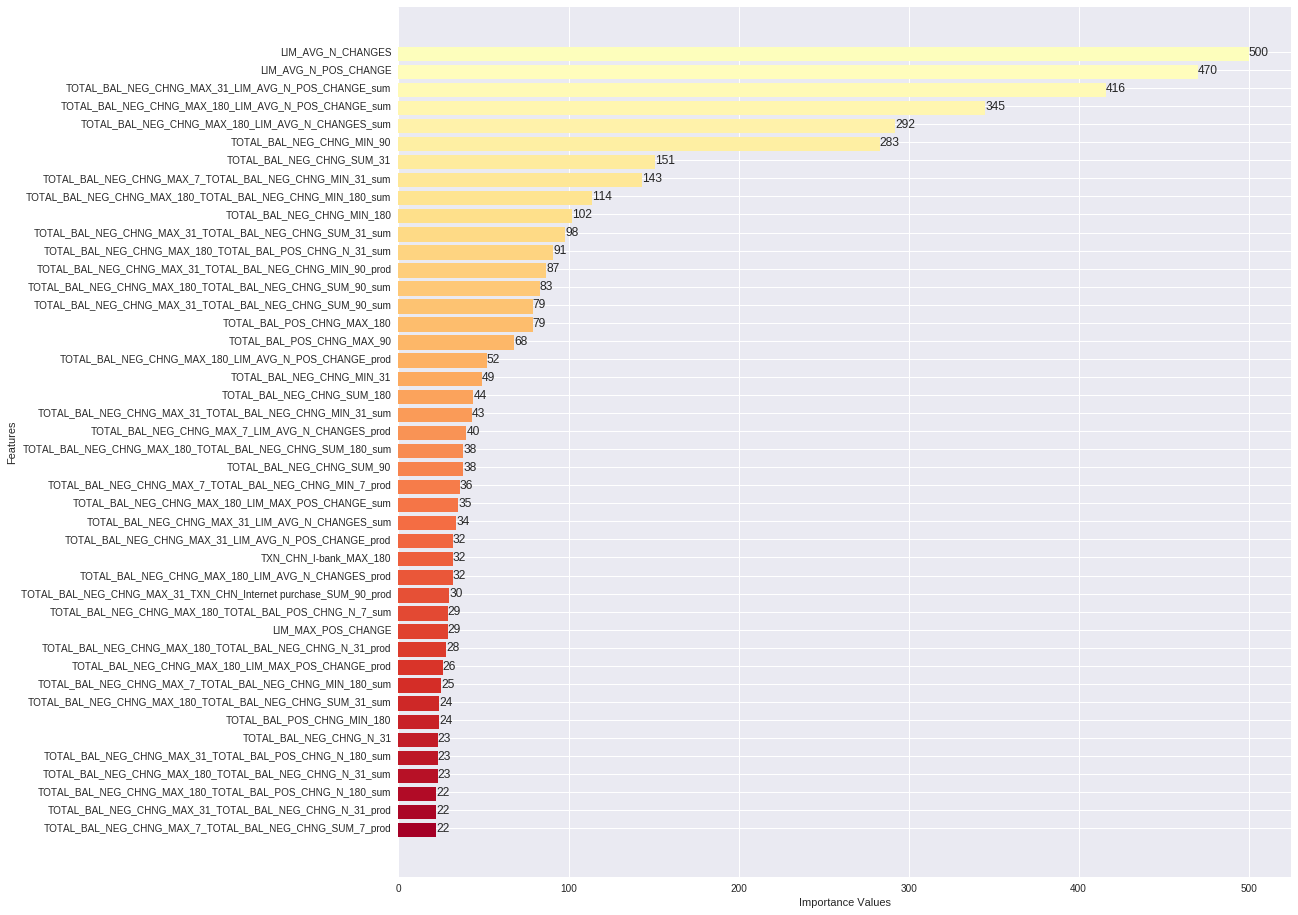

In [223]:
importances = bst.get_fscore()
f_names, f_values = zip(*sorted(importances.items(), key=lambda x: x[1]))

st_idx = len(f_names) / 2 + 230; end_idx = len(f_names) / 1;

fig = plt.figure(figsize=(16, 16))
plt.barh(np.arange(len(f_names[st_idx : end_idx])), f_values[st_idx : end_idx],
         color=[cm.RdYlGn(i * 3) for i in range(len(f_names[st_idx : end_idx]))])
fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])) + 0.1)
fig.axes[0].set_xlabel('Importance Values')
fig.axes[0].set_ylabel('Features')
fig.axes[0].set_label('Feature Importances')
for i, v in enumerate(f_values[st_idx : end_idx]):
    fig.axes[0].text(v + .02, i - 0.1, v)
plt.show()

## Multiple XGBoost models

In [138]:
## fit multiple models on subsamples of training data

In [196]:
from sklearn.utils import shuffle
from random import sample
from tqdm import tqdm_notebook as tqdm

## balanced dataset
class BalancedDataset():
    '''Generate batches.
    '''
    def __init__(self, X, y, batch_size=64):#X, y, batch_size=2):
        '''
        Args:
            X: feature matrix of size (n_samples, n_features);
            y: binary labels 0 and 1 of size (n_samples,);
            batch_size: total batch_size.
        '''

        self.n_features = X.shape[1]
        self.X = X.values
        self.y = y.values.astype(int)
        self.n_examples = y.shape[0]

        self.dict_examples = dict((k, shuffle(np.where(self.y == k)[0])) for k in np.unique(self.y))
        self.idx_examples = dict((k, 0) for k in np.unique(self.y))
        self.n_classes = len(self.idx_examples)
        self.batch_size = batch_size

    def _generate_batch(self):
        '''
        Generate batch of examples for a given class.

        Returns:
            Array of features with labels as the last column.
        '''
        arr_x = np.empty(shape=(self.batch_size, self.n_features))
        arr_y = np.empty(shape=(self.batch_size, ), dtype=np.int32)
        c_idx = 0 # current idx to fill
        need_examples = self.batch_size
        n_per_class = int(need_examples / self.n_classes)
        ## first take in each class as much as possible
        for i in range(self.n_classes):
            taken_class = n_per_class
            ## take with replacement from every class
            #while taken_class != 0:
            size_class = len(self.dict_examples[i])
            idx = self.idx_examples[i]
            n_ = min(idx + taken_class, size_class)
            add_ = n_ - idx
            taken_class -= add_
            arr_x[c_idx : (c_idx + add_), :] = self.X[self.dict_examples[i][idx : n_], :]
            arr_y[c_idx : (c_idx + add_)] = self.y[self.dict_examples[i][idx : n_]]
            c_idx += add_
            if n_ == size_class: # nullify and shuffle if the end is reached
                self.idx_examples[i] = 0
                self.dict_examples[i] = shuffle(self.dict_examples[i])
            else:
                self.idx_examples[i] = n_
        ## if need_examples > 0 then we can take
        ## by one example from some classes
        #sh_classes = shuffle(range(self.n_classes))
        while True:
            if need_examples - c_idx > 0: ## need to add examples
                ## choose random class
                i = sample(range(self.n_classes), 1)[0]#sh_classes.pop()
                size_class = len(self.dict_examples[i])
                idx = self.idx_examples[i]
                n_ = min(idx + 1, size_class)
                add_ = n_ - idx
                arr_x[c_idx : (c_idx + add_)] = self.X[self.dict_examples[i][idx : n_], :]
                arr_y[c_idx : (c_idx + add_)] = self.y[self.dict_examples[i][idx : n_]]
                c_idx += add_
                if n_ == size_class: # nullify and shuffle if the end is reached
                    self.idx_examples[i] = 0
                    self.dict_examples[i] = shuffle(self.dict_examples[i])
                else:
                    self.idx_examples[i] = n_
            else:
                break
        return (arr_x, arr_y)

In [227]:
n_per_class = 100
n_models = 1000

blncd_set = BalancedDataset(pd.concat([Xy_train, Xy_test],
                                      axis=0).drop(drop_cols_model, axis=1),
                            pd.concat([Xy_train, Xy_test]).label,
                           batch_size=n_per_class * (max_scenario + 1))

In [228]:
models = []
for _ in range(n_models):
    ### input data
    x_b, y_b = blncd_set._generate_batch()
    xg_trn = xgb_lib.DMatrix(x_b, 
                             label=y_b)
    c_config2 = dict(max_depth=5, eta=.05, n_estimators=50, seed=seed,
                                 reg_lambda=30, nthread=4, missing=np.nan,
                                 alpha=10, subsample=0.9, objective="multi:softprob",
                    num_class=max_scenario + 1,
                    max_delta_step=4.
                    )
    c_config2['lambda'] = c_config2['reg_lambda']

    bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])
    
    models.append(bst)

In [229]:
x_tb, y_tb = blncd_set._generate_batch()

In [230]:
preds = []
for idx, m_ in enumerate(models):
    xg_dt = xgb_lib.DMatrix(x_tb)
    preds.append(m_.predict(xg_dt))

In [231]:
preds_avg = np.stack(preds).mean(axis=0)

In [233]:
print(classification_report(y_tb, preds_avg.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.10      0.04      0.06        72
          1       0.16      0.29      0.21       110
          2       0.27      0.72      0.40       139
          3       0.20      0.14      0.17       134
          4       0.30      0.06      0.10       112
          5       0.23      0.08      0.12       144
          6       0.19      0.04      0.07       140
          7       0.00      0.00      0.00        57
          8       0.00      0.00      0.00        33
          9       0.20      0.57      0.30       141
         10       0.25      0.02      0.03        62
         11       0.00      0.00      0.00        56

avg / total       0.19      0.22      0.16      1200



In [234]:
## report
acc_df, df_cm = report_softmax(y_tb,
                               preds_avg,
                               n_classes=max_scenario + 1)
print(acc_df.T)
print(df_cm)
print()

               recall precision     fscore
all_labels   0.225833       NaN        NaN
0           0.0833333      0.12  0.0983607
1            0.254545       0.2      0.224
2             0.76259  0.267003   0.395522
3             0.61194  0.196172   0.297101
4           0.0714286  0.242424   0.110345
5           0.0694444  0.322581   0.114286
6                   0         0        NaN
7                   0       NaN        NaN
8                   0       NaN        NaN
9            0.219858  0.246032    0.23221
10                  0       NaN        NaN
11                  0       NaN        NaN
    0   1    2   3   4   5   6   7   8   9   10  11
0    6  13   20  21   5   1   0   0   0   6   0   0
1    9  28   48  19   1   0   0   0   0   5   0   0
2    5  12  106  10   3   0   0   0   0   3   0   0
3    3  14    8  82   2   3   0   0   0  22   0   0
4    8  19   51  18   8   0   1   0   0   7   0   0
5    5  10   29  61   4  10   0   0   0  25   0   0
6    5  11   28  72   3   2   0   

### Augmenting dataset

  * Choose at random an example of particular class
  * Choose at random a subset of non-dummy columns
  * Sample values from normal distribution with parameters
    calculated based on chosen columns from this class
  * Repeat until done

In [304]:
n_per_class = 1000

X_train_m = Xy_train.drop(drop_cols_model, axis=1).reset_index(drop=True)
y_train_m = Xy_train.label.reset_index(drop=True)

Xy_train_aug = []
sample_cols = ['AGE', 'QTY_CHLD']
counts = Counter(y_train_m)

for i in range(max_scenario + 1):
    while counts[i] < n_per_class:
        ## choose all instances of this class
        cls_i = X_train_m[y_train_m == i]
        ## sample how many columns to choose
        n_cols = np.random.randint(low=1, high=3)
        ## sample cols
        cols = sample(sample_cols, n_cols)
        ## sample single example
        cls_ind = cls_i.sample(1)
        ## sample new values for columns
        for c_ in cols:
            ## sample stats
            mean = cls_i[c_].mean()
            std = cls_i[c_].std()
            cls_ind[c_] = np.random.normal(mean, std)
        X_train_m = X_train_m.append(cls_ind)
        y_train_m = y_train_m.append(pd.Series(i))
        X_train_m = X_train_m.reset_index(drop=True)
        y_train_m = y_train_m.reset_index(drop=True)
        counts[i] += 1
    else:
        Xy_train_aug.append(pd
                            .concat([X_train_m, y_train_m], axis=1)[y_train_m == i]
                            .sample(n_per_class))

In [310]:
Counter(pd.concat(Xy_train_aug)[0])

Counter({0: 1000,
         1: 1000,
         2: 1000,
         3: 1000,
         4: 1000,
         5: 1000,
         6: 1000,
         7: 1000,
         8: 1000,
         9: 1000,
         10: 1000,
         11: 1000})

In [315]:
### input data
xg_trn = xgb_lib.DMatrix(pd.concat(Xy_train_aug).drop(0, axis=1), 
                         label=pd.concat(Xy_train_aug)[0])
xg_tst = xgb_lib.DMatrix(Xy_test.drop(drop_cols_model, axis=1), 
                         label=Xy_test.label)

c_config2 = dict(max_depth=6, eta=.035, n_estimators=220, seed=seed,
                             reg_lambda=30, nthread=4, missing=np.nan,
                             alpha=130, subsample=0.7, objective="multi:softprob",
                num_class=max_scenario + 1,
                max_delta_step=4.
                )
c_config2['lambda'] = c_config2['reg_lambda']

bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

preds_trn = bst.predict(xg_trn)
preds_tst = bst.predict(xg_tst)

In [318]:
## report
acc_df_trn, df_cm_trn = report_softmax(xg_trn.get_label(), 
                                       preds_trn, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(xg_tst.get_label(),
                                       preds_tst,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

           recall precision     fscore     recall  precision     fscore
all_labels  0.318       NaN        NaN   0.306147        NaN        NaN
0           0.022  0.261905  0.0405904          0          0        NaN
1           0.169  0.192483   0.179979       0.15  0.0294118  0.0491803
2           0.418  0.278481   0.334266      0.275  0.0833333   0.127907
3           0.613  0.211598   0.314601   0.596491   0.548387   0.571429
4           0.045  0.130814  0.0669643  0.0185185  0.0243902  0.0210526
5           0.198      0.25   0.220982  0.0588235     0.0625  0.0606061
6               0       NaN        NaN          0        NaN        NaN
7           0.584  0.377017   0.458219          0          0        NaN
8           0.848  0.898305   0.872428          0          0        NaN
9           0.181   0.17471     0.1778   0.162963  0.0916667   0.117333
10          0.642  0.343499   0.447543        0.3  0.0215827  0.0402685
11          0.096   0.90566   0.173599          0        NaN    

In [321]:
### roc for multi-class
y_dev_bin = label_binarize(xg_tst.get_label(), classes=range(max_scenario + 1))
n_classes = y_dev_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dev_bin[:, i], preds_tst[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_dev_bin.ravel(), preds_tst.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

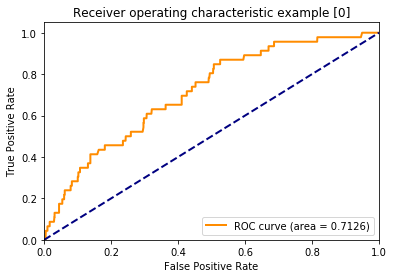

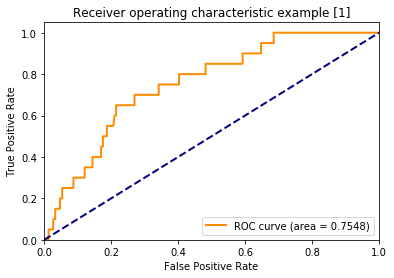

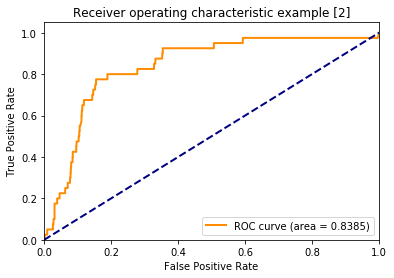

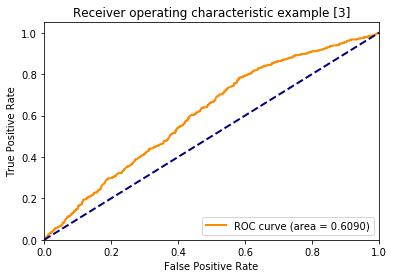

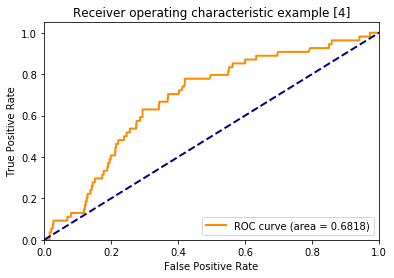

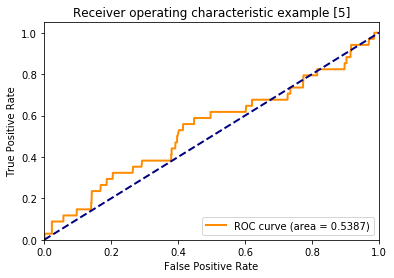

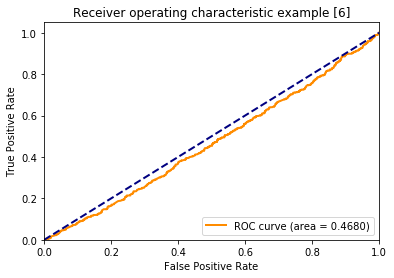

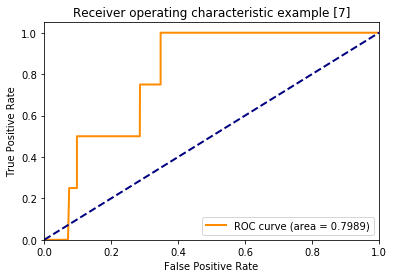

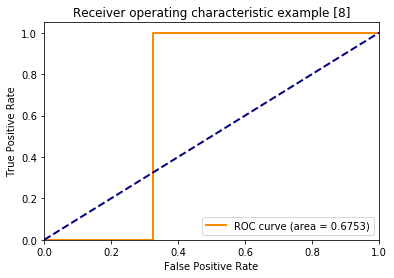

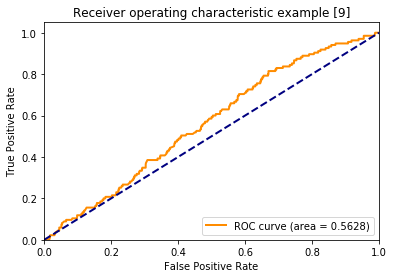

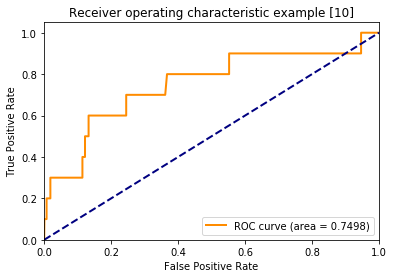

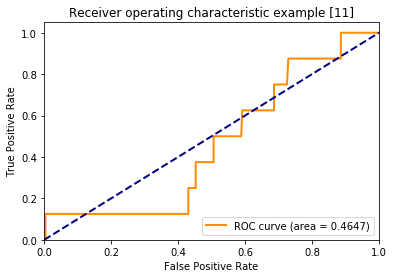

In [322]:
### plot for specific class
for plt_cls in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[plt_cls], tpr[plt_cls], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[plt_cls])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example [{}]'.format(plt_cls))
    plt.legend(loc="lower right")
    plt.show()

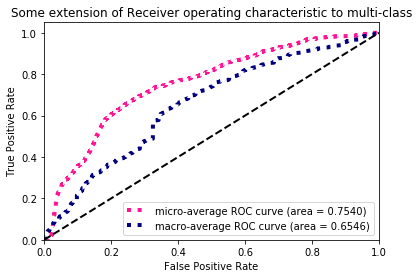

In [323]:
lw = 2


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Augmenting new balances dataset

  * Choose at random an example of particular class
  * Choose at random a subset of non-dummy columns
  * Sample values from normal distribution with parameters
    calculated based on chosen columns from this class
  * Repeat until done

In [4]:
campaigns_file = '../../../../projects/model/campaigns_2017-06-27_new_bal.csv'
df_usual = pd.read_csv(campaigns_file, sep=';', nrows=10)

In [5]:
ignore_cols = ['CONTRACT_REF', 
               'label', 'CONTROL_GROUP_FLG',
               'SCEN_CODE',
               'CHURN_LIMIT', 
               'SMS_CC'] + filter(lambda x: re.match('IS_LOYALTY', x),
                                       df_usual.columns)
drop_cols = ['CONTRACT_REF', 'PAYMENT', 'SCENARIO_NAME', 'DATE_START', 'DATE_END',
             'CLIENT_ID', 'REP_CLID', 'HAS_SD',
             'REP_RLCL_MAXCRIT', #'CONTROL_GROUP_FLG',
              u'FEE_RETURN',
              u'BINBONUS',
              u'POS_FEE',
              u'DAY_CATEGORY',
              u'RUBLE_PER_BONUS',
              u'DAY_PURCHASE',
              u'WEEKEND_PURCHASE',
              u'CHURN_LIMIT',
             'FL_P24'] + filter(lambda x: re.match('LIM', x),
                                       df_usual.columns)
scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = False
seed = 42
test_size = 0.15

In [6]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=campaigns_file,
                          ignore_cols_dummy=ignore_cols,
                          ignore_cols_norm=ignore_cols + ['HAS_CHLD'],
                          drop_cols=drop_cols,
                          dummy_config=dummy_config,
                          fill_na=fill_na,
                          scaler=scaler,
                          transform_dict=None,
                          normalise_dict=None,
                          test_size=test_size,
                          seed=seed,
                          verbose=False)

In [7]:
### {ctrl_flg + sms_cc} -> {00, 10, 11} => 00 = CTRL_GROUP; 10 = SMS; 01 = CALL_CENTRE
Xy_train['SMS'] = 0; Xy_train['CC'] = 0;
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 1) , 'SMS'] = 1
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 0) , 'CC'] = 1
Xy_train = Xy_train.drop(['CONTROL_GROUP_FLG', 'SMS_CC'], axis=1)

Xy_test['SMS'] = 0; Xy_test['CC'] = 0;
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 1) , 'SMS'] = 1
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 0) , 'CC'] = 1
Xy_test = Xy_test.drop(['CONTROL_GROUP_FLG', 'SMS_CC'], axis=1)

In [9]:
## only on those who responded
Xy_train = Xy_train[Xy_train.label == 1].dropna()
Xy_test = Xy_test[Xy_test.label == 1].dropna()

In [10]:
### convert labels to 0 to max_scenario + 1
max_scenario = 11
Xy_train['label'] = Xy_train.SCEN_CODE.astype(int)
Xy_test['label'] = Xy_test.SCEN_CODE.astype(int)

In [18]:
drop_cols_model = ['label', 'SCEN_CODE']

In [11]:
Counter(pd.concat([Xy_train, Xy_test]).label)

Counter({0: 97,
         1: 13,
         2: 32,
         3: 1376,
         4: 48,
         5: 34,
         6: 1221,
         7: 5,
         8: 2,
         9: 134,
         10: 14,
         11: 5})

In [74]:
n_per_class = 460

X_train_m = Xy_train.drop(drop_cols_model, axis=1).reset_index(drop=True)
y_train_m = Xy_train.label.reset_index(drop=True)

Xy_train_aug = []
sample_cols = (['AGE', 'QTY_CHLD'] + 
               filter(lambda x: re.match('.*DEBT,*|.*BAL.*', x), X_train_m.columns))
counts = Counter(y_train_m)
min_cols = 5
max_cols = 17

for i in range(max_scenario + 1):
    while counts[i] < n_per_class:
        ## choose all instances of this class
        cls_i = X_train_m[y_train_m == i]
        ## sample how many columns to choose
        n_cols = np.random.randint(low=min(len(sample_cols), min_cols),
                                   high=min(len(sample_cols), max_cols))
        ## sample cols
        cols = sample(sample_cols, n_cols)
        ## sample single example
        cls_ind = cls_i.sample(1)
        ## sample new values for columns
        for c_ in cols:
            ## sample stats
            mean = cls_i[c_].mean()
            std = cls_i[c_].std()
            ## add random noise or sample
            cls_ind[c_] += np.random.uniform(-.01, 0.01)#np.clip(np.random.normal(mean, std),
                          #        cls_i[c_].min(), cls_i[c_].max())
        X_train_m = X_train_m.append(cls_ind)
        y_train_m = y_train_m.append(pd.Series(i))
        X_train_m = X_train_m.reset_index(drop=True)
        y_train_m = y_train_m.reset_index(drop=True)
        counts[i] += 1
    else:
        Xy_train_aug.append(pd
                            .concat([X_train_m, y_train_m], axis=1)[y_train_m == i]
                            .sample(n_per_class))

In [61]:
Counter(pd.concat(Xy_train_aug)[0])

Counter({0: 260,
         1: 260,
         2: 260,
         3: 260,
         4: 260,
         5: 260,
         6: 260,
         7: 260,
         8: 260,
         9: 260,
         10: 260,
         11: 260})

In [62]:
Counter(Xy_test.label)

Counter({0: 13, 1: 4, 2: 4, 3: 211, 4: 10, 5: 6, 6: 187, 7: 1, 9: 17, 10: 1})

In [63]:
print("Aug trainset shape : {}".format(pd.concat(Xy_train_aug).shape))

Aug trainset shape : (3120, 95)


In [75]:
Xy_train_aug = shuffle(pd.concat(Xy_train_aug))

In [76]:
### input data
#
xg_trn = xgb_lib.DMatrix(Xy_train_aug.drop(0, axis=1), 
                         label=Xy_train_aug[0])
xg_tst = xgb_lib.DMatrix(Xy_test.drop(drop_cols_model, axis=1), 
                         label=Xy_test.label)

c_config2 = dict(max_depth=5, eta=.05, n_estimators=120, seed=seed,
                             reg_lambda=30, nthread=4, missing=np.nan,
                             alpha=30, subsample=0.9, objective="multi:softprob",
                num_class=max_scenario + 1,
                max_delta_step=1.
                )
c_config2['lambda'] = c_config2['reg_lambda']

bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

preds_trn = bst.predict(xg_trn)
preds_tst = bst.predict(xg_tst)

In [77]:
## report
acc_df_trn, df_cm_trn = report_softmax(xg_trn.get_label(), 
                                       preds_trn, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(xg_tst.get_label(),
                                       preds_tst,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall precision    fscore
all_labels  0.888225       NaN       NaN  0.475771       NaN       NaN
0           0.902174  0.778612  0.835851  0.692308  0.147541  0.243243
1           0.984783  0.965885  0.975242      0.25       0.2  0.222222
2           0.997826  0.960251  0.978678       0.5       0.5       0.5
3           0.458696  0.657321  0.540333  0.393365  0.638462  0.486804
4           0.934783  0.909091  0.921758       0.5  0.454545   0.47619
5           0.932609  0.934641  0.933624  0.166667       0.1     0.125
6           0.630435  0.682353  0.655367   0.57754  0.586957   0.58221
7                  1  0.962343   0.98081         0         0       NaN
8                  1         1         1       NaN       NaN       NaN
9           0.819565  0.783784  0.801275  0.411765  0.162791  0.233333
10          0.997826  0.960251  0.978678         0         0       NaN
11                 1  0.989247  0.994595       NaN         0       NaN
     0

In [78]:
### roc for multi-class
y_dev_bin = label_binarize(xg_tst.get_label(), classes=range(max_scenario + 1))
n_classes = y_dev_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dev_bin[:, i], preds_tst[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_dev_bin.ravel(), preds_tst.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

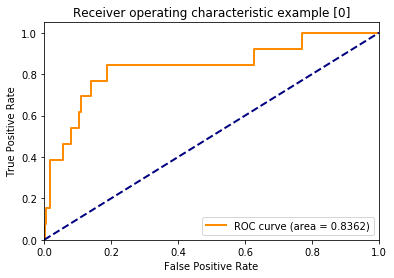

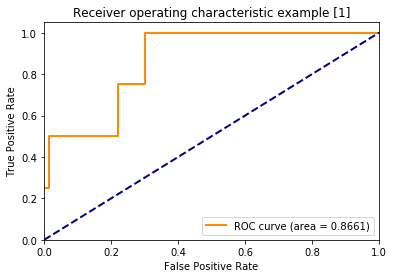

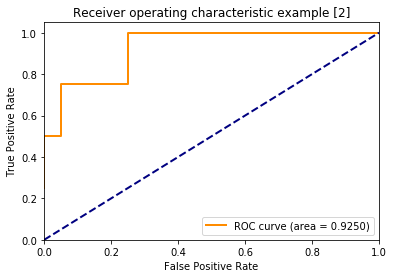

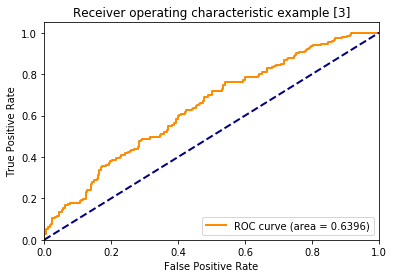

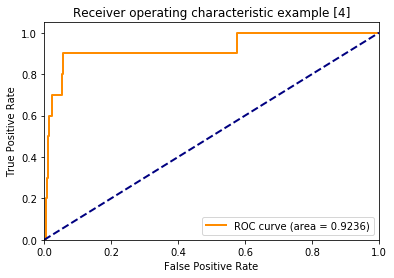

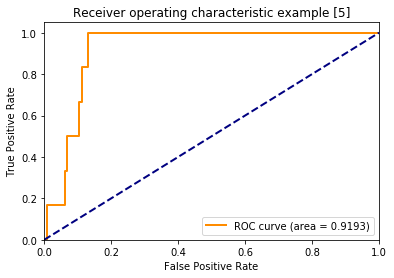

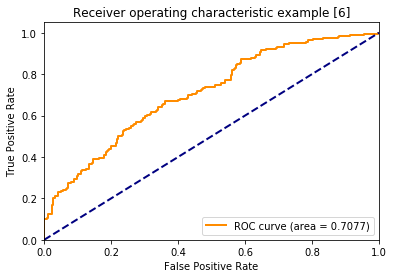

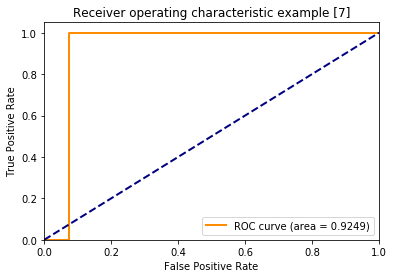

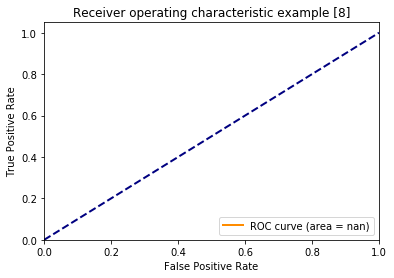

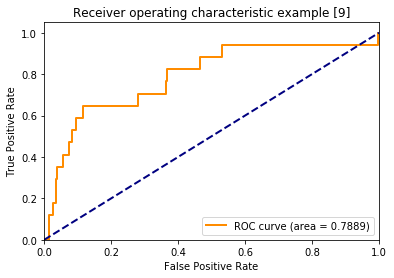

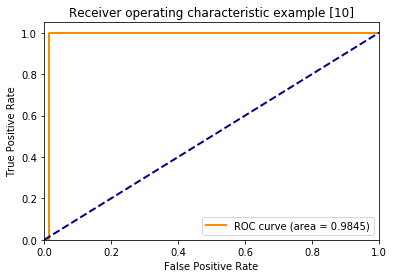

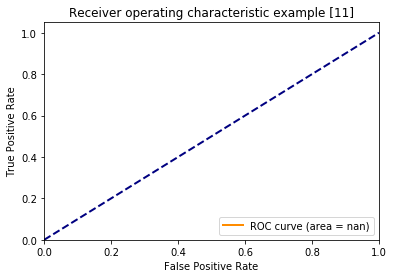

In [79]:
### plot for specific class
for plt_cls in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[plt_cls], tpr[plt_cls], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[plt_cls])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example [{}]'.format(plt_cls))
    plt.legend(loc="lower right")
    plt.show()

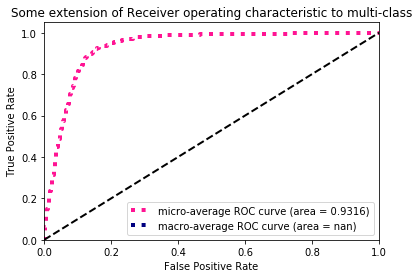

In [80]:
lw = 2


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Augmenting new balances dataset with SVD

In [28]:
from numpy.linalg import svd

In [5]:
campaigns_file = '../../../../projects/model/campaigns_2017-06-27_new_bal.csv'
df_usual = pd.read_csv(campaigns_file, sep=';', nrows=10)

In [6]:
ignore_cols = ['CONTRACT_REF', 
               'label', 'CONTROL_GROUP_FLG',
               'SCEN_CODE',
               'CHURN_LIMIT', 
               'SMS_CC'] + filter(lambda x: re.match('IS_LOYALTY', x),
                                       df_usual.columns)
drop_cols = ['CONTRACT_REF', 'PAYMENT', 'SCENARIO_NAME', 'DATE_START', 'DATE_END',
             'CLIENT_ID', 'REP_CLID', 'HAS_SD',
             'REP_RLCL_MAXCRIT', #'CONTROL_GROUP_FLG',
              u'FEE_RETURN',
              u'BINBONUS',
              u'POS_FEE',
              u'DAY_CATEGORY',
              u'RUBLE_PER_BONUS',
              u'DAY_PURCHASE',
              u'WEEKEND_PURCHASE',
              u'CHURN_LIMIT',
             'FL_P24'] + filter(lambda x: re.match('LIM', x),
                                       df_usual.columns)
scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = False
seed = 42
test_size = 0.15

In [7]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=campaigns_file,
                          ignore_cols_dummy=ignore_cols,
                          ignore_cols_norm=ignore_cols + ['HAS_CHLD'],
                          drop_cols=drop_cols,
                          dummy_config=dummy_config,
                          fill_na=fill_na,
                          scaler=scaler,
                          transform_dict=None,
                          normalise_dict=None,
                          test_size=test_size,
                          seed=seed,
                          verbose=False)

In [8]:
### {ctrl_flg + sms_cc} -> {00, 10, 11} => 00 = CTRL_GROUP; 10 = SMS; 01 = CALL_CENTRE
Xy_train['SMS'] = 0; Xy_train['CC'] = 0;
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 1) , 'SMS'] = 1
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 0) , 'CC'] = 1
Xy_train = Xy_train.drop(['CONTROL_GROUP_FLG', 'SMS_CC'], axis=1)

Xy_test['SMS'] = 0; Xy_test['CC'] = 0;
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 1) , 'SMS'] = 1
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 0) , 'CC'] = 1
Xy_test = Xy_test.drop(['CONTROL_GROUP_FLG', 'SMS_CC'], axis=1)

In [9]:
## only on those who responded
Xy_train = Xy_train[Xy_train.label == 1].dropna()
Xy_test = Xy_test[Xy_test.label == 1].dropna()

In [10]:
### convert labels to 0 to max_scenario + 1
max_scenario = 11
Xy_train['label'] = Xy_train.SCEN_CODE.astype(int)
Xy_test['label'] = Xy_test.SCEN_CODE.astype(int)

In [11]:
drop_cols_model = ['label', 'SCEN_CODE']

In [12]:
Counter(pd.concat([Xy_train, Xy_test]).label)

Counter({0: 97,
         1: 13,
         2: 32,
         3: 1376,
         4: 48,
         5: 34,
         6: 1221,
         7: 5,
         8: 2,
         9: 134,
         10: 14,
         11: 5})

In [29]:
svd_cols = (['AGE', 'QTY_CHLD'] + 
               filter(lambda x: re.match('.*DEBT,*|.*BAL.*', x), Xy_train.columns))

In [83]:
n_per_class = 460
top_k_prcnt = 0.8 # how many largest eigenvalues to keep
assert top_k < len(svd_cols), "The number of top-k must be less than the total number of columns"
X_train_m = Xy_train.drop(drop_cols_model, axis=1).reset_index(drop=True)
y_train_m = Xy_train.label.reset_index(drop=True)

Xy_train_aug = []
counts = Counter(y_train_m)

for i in range(max_scenario + 1):
    while counts[i] < n_per_class:
        ## choose all instances of this class
        cls_i = X_train_m[y_train_m == i]
        ## svd decomposition
        U, s, V = np.linalg.svd(cls_i[svd_cols], full_matrices=False)
        ## replace n - top_k with random numbers
        top_k = int(len(s) * top_k_prcnt)
        s[top_k : ] = sorted(np.random.uniform(s[-1], s[top_k], size=len(s) - top_k),
                             reverse=True)
        S = np.diag(s)
        #S = np.zeros((len(U), len(s)), dtype=complex)
        #S[:len(s), :len(s)] = np.diag(s)
        new_X = np.dot(U, np.dot(S, V))
        X_train_m = X_train_m.append(pd.concat([pd.DataFrame(new_X, index=cls_i.index, 
                                                             columns=svd_cols),
                                                cls_i.drop(svd_cols, axis=1)], axis=1))
        y_train_m = y_train_m.append(pd.Series(np.repeat(i, len(new_X))))
        X_train_m = X_train_m.reset_index(drop=True)
        y_train_m = y_train_m.reset_index(drop=True)
        counts[i] += len(new_X)
    else:
        Xy_train_aug.append(pd
                            .concat([X_train_m, y_train_m], axis=1)[y_train_m == i]
                            .sample(n_per_class))

In [84]:
Counter(pd.concat(Xy_train_aug)[0])

Counter({0: 460,
         1: 460,
         2: 460,
         3: 460,
         4: 460,
         5: 460,
         6: 460,
         7: 460,
         8: 460,
         9: 460,
         10: 460,
         11: 460})

In [62]:
Counter(Xy_test.label)

Counter({0: 13, 1: 4, 2: 4, 3: 211, 4: 10, 5: 6, 6: 187, 7: 1, 9: 17, 10: 1})

In [85]:
print("Aug trainset shape : {}".format(pd.concat(Xy_train_aug).shape))

Aug trainset shape : (5520, 95)


In [86]:
Xy_train_aug = shuffle(pd.concat(Xy_train_aug))

In [90]:
### input data
#
xg_trn = xgb_lib.DMatrix(Xy_train_aug.drop(0, axis=1), 
                         label=Xy_train_aug[0])
xg_tst = xgb_lib.DMatrix(Xy_test[xg_trn.feature_names], 
                         label=Xy_test.label)

c_config2 = dict(max_depth=5, eta=.05, n_estimators=120, seed=seed,
                             reg_lambda=30, nthread=4, missing=np.nan,
                             alpha=30, subsample=0.9, objective="multi:softprob",
                num_class=max_scenario + 1,
                max_delta_step=1.
                )
c_config2['lambda'] = c_config2['reg_lambda']

bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

preds_trn = bst.predict(xg_trn)
preds_tst = bst.predict(xg_tst)

In [91]:
## report
acc_df_trn, df_cm_trn = report_softmax(xg_trn.get_label(), 
                                       preds_trn, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(xg_tst.get_label(),
                                       preds_tst,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall  precision    fscore
all_labels  0.869565       NaN       NaN  0.433921        NaN       NaN
0           0.834783  0.737044  0.782875  0.769231   0.136986  0.232558
1                  1  0.968421  0.983957         0          0       NaN
2           0.971739  0.978118  0.974918       0.5        0.5       0.5
3                0.4  0.564417  0.468193  0.350711   0.672727  0.461059
4           0.928261  0.902748  0.915327       0.5   0.416667  0.454545
5           0.932609  0.924569  0.928571  0.333333   0.222222  0.266667
6           0.615217  0.678657  0.645382  0.524064   0.573099  0.547486
7                  1  0.968421  0.983957         0          0       NaN
8                  1  0.997831  0.998914       NaN        NaN       NaN
9           0.752174  0.703252  0.726891  0.352941  0.0967742  0.151899
10                 1  0.960334  0.979766         0          0       NaN
11                 1  0.958333  0.978723       NaN          0   

In [92]:
### roc for multi-class
y_dev_bin = label_binarize(xg_tst.get_label(), classes=range(max_scenario + 1))
n_classes = y_dev_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dev_bin[:, i], preds_tst[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_dev_bin.ravel(), preds_tst.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

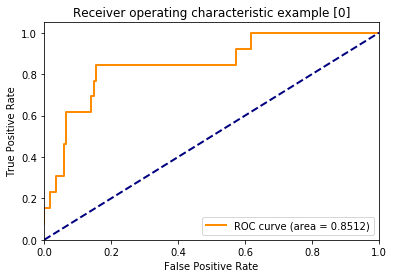

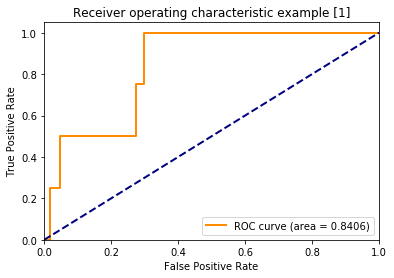

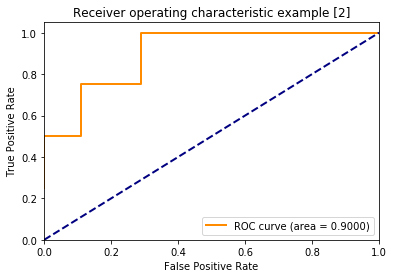

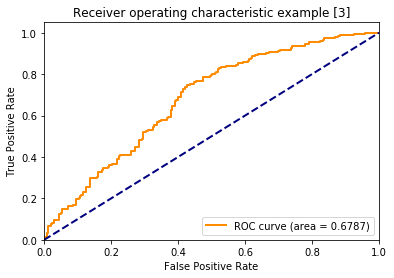

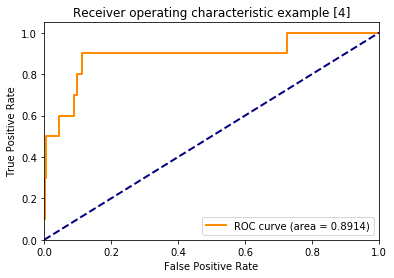

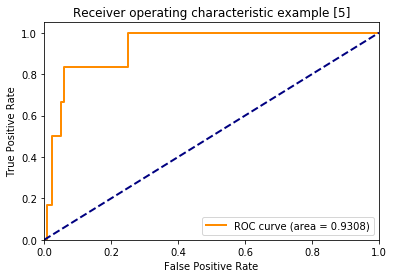

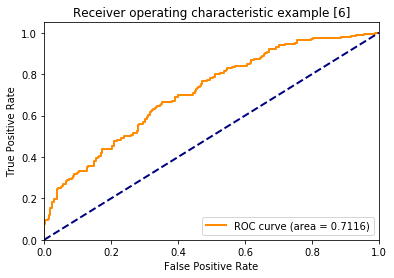

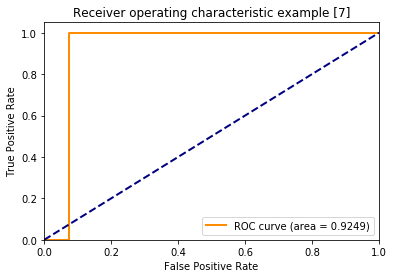

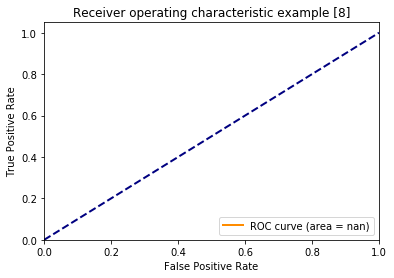

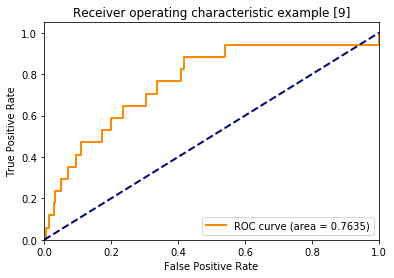

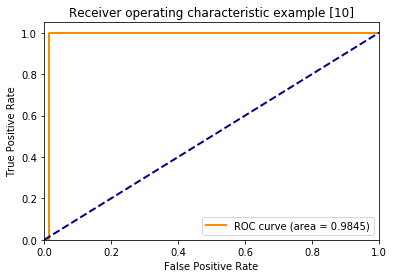

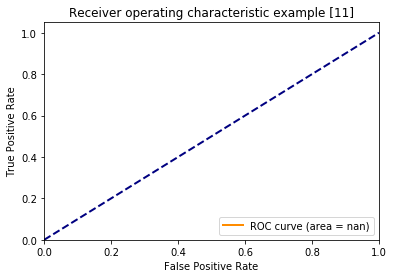

In [93]:
### plot for specific class
for plt_cls in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(fpr[plt_cls], tpr[plt_cls], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[plt_cls])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example [{}]'.format(plt_cls))
    plt.legend(loc="lower right")
    plt.show()

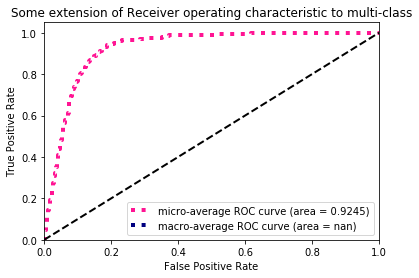

In [94]:
lw = 2


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Different models

In [371]:
campaigns_file = '../../../../projects/model/campaigns_2017-06-21_bal_12_coeff_0.056.csv'
df_usual = pd.read_csv(campaigns_file, sep=';', nrows=10)

In [372]:
ignore_cols = ['CONTRACT_REF', 'SCEN_CODE',
               'label', 'CONTROL_GROUP_FLG',
               'CHURN_LIMIT', 
               'SMS_CC'] + filter(lambda x: re.match('IS_LOYALTY', x),
                                       df_usual.columns)
drop_cols = ['CONTRACT_REF', 'PAYMENT', 'SCENARIO_NAME', 'DATE_START', 'DATE_END',
             'CLIENT_ID', 'REP_CLID', 
             #'SCEN_CODE',
             'HAS_SD',
             'REP_RLCL_MAXCRIT', #'CONTROL_GROUP_FLG',
              u'FEE_RETURN',
              u'BINBONUS',
              u'POS_FEE',
              u'DAY_CATEGORY',
              u'RUBLE_PER_BONUS',
              u'DAY_PURCHASE',
              u'WEEKEND_PURCHASE',
              u'CHURN_LIMIT',
             'FL_P24'] + filter(lambda x: re.match('IS_LOYALTY|.*BAL.*|LIM', x),
                                       df_usual.columns)
scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = True
seed = 42
test_size = 0.15

In [373]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=campaigns_file,
                          ignore_cols_dummy=ignore_cols,
                          ignore_cols_norm=ignore_cols + ['HAS_CHLD'],
                          drop_cols=drop_cols,
                          dummy_config=dummy_config,
                          fill_na=fill_na,
                          scaler=scaler,
                          transform_dict=None,
                          normalise_dict=None,
                          test_size=test_size,
                          seed=seed,
                          verbose=False)

In [374]:
### {ctrl_flg + sms_cc} -> {00, 10, 11} => 00 = CTRL_GROUP; 10 = SMS; 01 = CALL_CENTRE
Xy_train['SMS'] = 0; Xy_train['CC'] = 0;
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 1) , 'SMS'] = 1
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 0) , 'CC'] = 1
Xy_train = Xy_train.drop(['CONTROL_GROUP_FLG', 'SMS_CC'], axis=1)

Xy_test['SMS'] = 0; Xy_test['CC'] = 0;
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 1) , 'SMS'] = 1
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 0) , 'CC'] = 1
Xy_test = Xy_test.drop(['CONTROL_GROUP_FLG', 'SMS_CC'], axis=1)

In [375]:
## only on those who responded
Xy_train = Xy_train[Xy_train.label == 1].dropna()
Xy_test = Xy_test[Xy_test.label == 1].dropna()

In [376]:
### convert labels to 0 to max_scenario + 1
max_scenario = 11
Xy_train['label'] = Xy_train.SCEN_CODE.astype(int)
Xy_test['label'] = Xy_test.SCEN_CODE.astype(int)

Xy_train = Xy_train.drop(['SCEN_CODE'], axis=1)
Xy_test = Xy_test.drop(['SCEN_CODE'], axis=1)

In [377]:
all_X = pd.concat([Xy_train, Xy_test], axis=0).drop('label', axis=1)
all_y = pd.concat([Xy_train, Xy_test])['label']

In [378]:
clf = DecisionTreeClassifier(min_samples_leaf=10)
predicted = cross_validation.cross_val_predict(clf, all_X, all_y, cv=5)
metrics.accuracy_score(all_y, predicted)

0.50819829322082655

In [379]:
print(classification_report(all_y, predicted))

             precision    recall  f1-score   support

          0       0.22      0.12      0.16       754
          1       0.07      0.00      0.01       242
          2       0.10      0.05      0.07       460
          3       0.59      0.78      0.67     11068
          4       0.07      0.01      0.01       588
          5       0.00      0.00      0.00       502
          6       0.35      0.34      0.34      5449
          7       0.00      0.00      0.00        43
          8       0.00      0.00      0.00        10
          9       0.07      0.01      0.01      1556
         10       0.00      0.00      0.00        75
         11       0.00      0.00      0.00       111

avg / total       0.42      0.51      0.45     20858



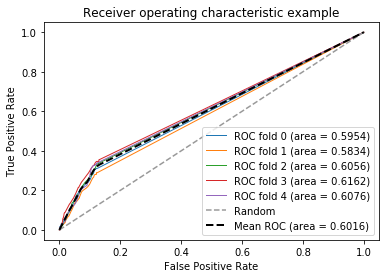

In [356]:
plot_ROC_curve(DecisionTreeClassifier(min_samples_leaf=10), 
               X=all_X.values, y=all_y.values)

In [381]:
clf = LogisticRegression()
predicted = cross_validation.cross_val_predict(clf, all_X, all_y, cv=5)
metrics.accuracy_score(all_y, predicted)

0.53777926934509546

In [382]:
print(classification_report(all_y, predicted))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       754
          1       0.00      0.00      0.00       242
          2       0.00      0.00      0.00       460
          3       0.57      0.92      0.70     11068
          4       0.00      0.00      0.00       588
          5       0.00      0.00      0.00       502
          6       0.34      0.18      0.24      5449
          7       0.00      0.00      0.00        43
          8       0.00      0.00      0.00        10
          9       0.00      0.00      0.00      1556
         10       0.00      0.00      0.00        75
         11       0.00      0.00      0.00       111

avg / total       0.39      0.54      0.44     20858



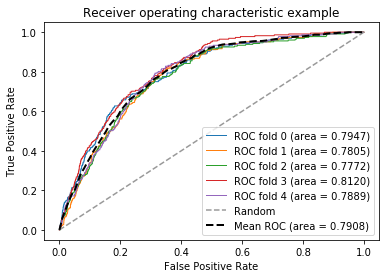

In [357]:
plot_ROC_curve(LogisticRegression(), 
               X=all_X.values, y=all_y.values)

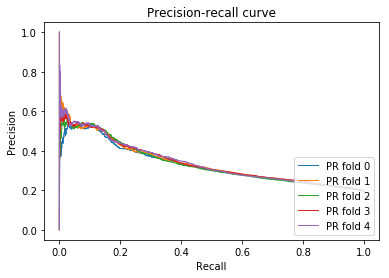

In [37]:
plot_PR_curve(LogisticRegression(), 
               X=all_X.values, y=all_y.values)

In [383]:
clf = RandomForestClassifier(n_estimators=50)
predicted = cross_validation.cross_val_predict(clf, all_X, all_y, cv=5)
metrics.accuracy_score(all_y, predicted)

0.45867293124940073

In [384]:
print(classification_report(all_y, predicted))

             precision    recall  f1-score   support

          0       0.13      0.09      0.11       754
          1       0.02      0.01      0.02       242
          2       0.15      0.11      0.13       460
          3       0.60      0.67      0.63     11068
          4       0.08      0.05      0.06       588
          5       0.02      0.01      0.01       502
          6       0.34      0.34      0.34      5449
          7       0.00      0.00      0.00        43
          8       0.00      0.00      0.00        10
          9       0.11      0.07      0.09      1556
         10       0.00      0.00      0.00        75
         11       0.00      0.00      0.00       111

avg / total       0.43      0.46      0.44     20858



In [385]:
Counter(predicted)

Counter({0: 543,
         1: 156,
         2: 336,
         3: 12366,
         4: 385,
         5: 310,
         6: 5515,
         7: 27,
         8: 5,
         9: 1102,
         10: 53,
         11: 60})

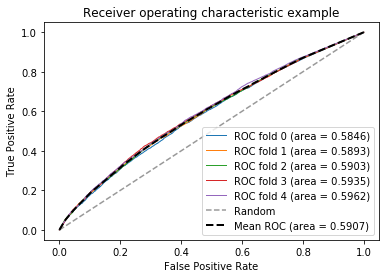

In [38]:
plot_ROC_curve(RandomForestClassifier(n_estimators=50), 
               X=all_X.values, y=all_y.values)

In [365]:
clf = GradientBoostingClassifier()
predicted = cross_validation.cross_val_predict(clf, all_X, all_y, cv=5)
print(metrics.accuracy_score(all_y, predicted))

print(classification_report(all_y, predicted))

Counter(predicted)

0.393580256189
             precision    recall  f1-score   support

          0       0.27      0.04      0.07      1861
          1       0.00      0.00      0.00      1139
          2       0.38      0.80      0.52     10192
          3       0.46      0.51      0.48     24716
          4       0.00      0.00      0.00      3531
          5       0.26      0.01      0.01     10104
          6       0.31      0.06      0.10     14827
          7       0.10      0.00      0.00      2692
          8       0.00      0.00      0.00        22
          9       0.36      0.77      0.49     24308
         10       0.29      0.00      0.00      3038
         11       0.73      0.14      0.24     10054

avg / total       0.38      0.39      0.31    106484



Counter({0: 294,
         1: 1,
         2: 21263,
         3: 27313,
         4: 3,
         5: 195,
         6: 2948,
         7: 29,
         9: 52447,
         10: 14,
         11: 1977})

### campaigns+transactions data

In [386]:
campaigns_file = '../../../../projects/model/campaigns_2017-06-21_bal_12_coeff_0.056.csv'
transactions_file = '../../../../projects/model/transactions_2017-06-21_agg_45_recent_20.csv'

In [387]:
df_usual = pd.read_csv(campaigns_file, sep=';', nrows=10)

In [388]:
df_trns = pd.read_csv(transactions_file, sep=';', nrows=10)

In [389]:
ignore_cols = ['CONTRACT_REF', 'DATE_START',
               'SCEN_CODE',
               'label', 'CONTROL_GROUP_FLG', 
               'CHURN_LIMIT', 
               'SMS_CC'] + filter(lambda x: re.match('IS_LOYALTY', x),
                                       df_usual.columns)
drop_cols = ['PAYMENT', 'SCENARIO_NAME', 'DATE_END',
             'CLIENT_ID', 'REP_CLID', 
             #'SCEN_CODE',
             'HAS_SD',
             'REP_RLCL_MAXCRIT', #'CONTROL_GROUP_FLG',
              u'FEE_RETURN',
              u'BINBONUS',
              u'POS_FEE',
              u'DAY_CATEGORY',
              u'RUBLE_PER_BONUS',
              u'DAY_PURCHASE',
              u'WEEKEND_PURCHASE',
              u'CHURN_LIMIT',
             'FL_P24'] + filter(lambda x: re.match('IS_LOYALTY|.*BAL.*|LIM', x),
                                       df_usual.columns)
scaler = 'standard'
dummy_config = (15, 0.9)
fill_na = False
seed = 42
test_size = 0.15

In [390]:
Xy_train, Xy_test, _, _ = create_sets(path_to_file=campaigns_file,
                          ignore_cols_dummy=ignore_cols,
                          ignore_cols_norm=ignore_cols + ['HAS_CHLD'],
                          drop_cols=drop_cols,
                          dummy_config=dummy_config,
                          fill_na=fill_na,
                          scaler=scaler,
                          transform_dict=None,
                          normalise_dict=None,
                          test_size=test_size,
                          seed=seed,
                          verbose=False)

In [391]:
### {ctrl_flg + sms_cc} -> {00, 10, 11} => 00 = CTRL_GROUP; 10 = SMS; 01 = CALL_CENTRE
Xy_train['SMS'] = 0; Xy_train['CC'] = 0;
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 1) , 'SMS'] = 1
Xy_train.loc[(Xy_train.CONTROL_GROUP_FLG == 'N') & (Xy_train.SMS_CC == 0) , 'CC'] = 1

Xy_test['SMS'] = 0; Xy_test['CC'] = 0;
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 1) , 'SMS'] = 1
Xy_test.loc[(Xy_test.CONTROL_GROUP_FLG == 'N') & (Xy_test.SMS_CC == 0) , 'CC'] = 1

## only on those who responded
Xy_train = Xy_train[Xy_train.label == 1].dropna()
Xy_test = Xy_test[Xy_test.label == 1].dropna()

### convert labels to 0 to max_scenario + 1
max_scenario = 11
Xy_train['label'] = Xy_train.SCEN_CODE.astype(int)
Xy_test['label'] = Xy_test.SCEN_CODE.astype(int)

Xy_train = Xy_train.drop(['CONTROL_GROUP_FLG', 'SMS_CC', 'SCEN_CODE'], axis=1)
Xy_test = Xy_test.drop(['CONTROL_GROUP_FLG', 'SMS_CC', 'SCEN_CODE'], axis=1)

In [392]:
t_train, t_test, _, _ = create_sets(path_to_file=transactions_file,
                                      ignore_cols_dummy=['CONTRACT_REF', 'DATE_START', 'n_trns'],
                                      ignore_cols_norm=ignore_cols + ['CODE', 'n_trns'],
                                      drop_cols=[],
                                      dummy_config=dummy_config,
                                      fill_na=fill_na,
                                      scaler=scaler,
                                      transform_dict=None,
                                      normalise_dict=None,
                                      test_size=0,
                                      trn_ids=Xy_train[['CONTRACT_REF', 'DATE_START']],
                                      tst_ids=Xy_test[['CONTRACT_REF', 'DATE_START']],
                                      seed=seed,
                                      verbose=True)

PROCESSING OBJECT COLUMN : CODE
***************
KEEPING TOP-15 VALUES OUT OF 67
***************
PROCESSING NUMERIC COLUMN : TXN_RUB_AMT
***************
PROCESSING OBJECT COLUMN : TXN_TP
***************
KEEPING TOP-3 VALUES OUT OF 5
***************
PROCESSING NUMERIC COLUMN : n_days
***************
NORMALISING COLUMN : TXN_RUB_AMT
***************
NORMALISING COLUMN : n_days
***************
NORMALISING COLUMN : TXN_RUB_AMT
***************
NORMALISING COLUMN : n_days
***************


In [393]:
## prepare_trns for modelling
t_train = prepare_trns(t_train, 
                       Xy_train[['CONTRACT_REF', 'DATE_START']], 
                       verbose=True)
t_test = prepare_trns(t_test, 
                      Xy_test[['CONTRACT_REF', 'DATE_START']], 
                      verbose=True)

GENERATING OUTPUT OF SIZE [9569, 20, 21]
***************
GENERATING OUTPUT OF SIZE [1692, 20, 21]
***************


In [394]:
drop_cols_model = ['CONTRACT_REF', 'DATE_START', 'label']

In [395]:
all_X = np.concatenate(
    [pd.concat([Xy_train, Xy_test], axis=0).drop(drop_cols_model, axis=1).values,
     np.concatenate([t_train, t_test], axis=0).reshape([len(t_train) + len(t_test), -1])], 
    axis=1)
all_y = pd.concat([Xy_train, Xy_test], axis=0)['label']

In [396]:
print("All X shape : {}".format(all_X.shape))

All X shape : (11261, 443)


In [399]:
drop_cols_model = ['CONTRACT_REF', 'DATE_START', 'label']

In [422]:
### input data
w_dict = {x : 6 for x in range(max_scenario + 1)}
w_dict[3] = 1; w_dict[6] = 1; w_dict[9] = 2

xg_trn = xgb_lib.DMatrix(np.concatenate([Xy_train.drop(drop_cols_model, axis=1).values,
                                         t_train.reshape([len(t_train), -1])], axis=1), 
                         label=Xy_train.label,
                         weight=[w_dict[y] for y in Xy_train.label])
xg_tst = xgb_lib.DMatrix(np.concatenate([Xy_test.drop(drop_cols_model, axis=1).values,
                                         t_test.reshape([len(t_test), -1])], axis=1), 
                         label=Xy_test.label)

c_config2 = dict(max_depth=6, eta=.035, n_estimators=220, seed=seed,
                             reg_lambda=30, nthread=4, missing=np.nan,
                             alpha=130, subsample=0.7, objective="multi:softprob",
                num_class=max_scenario + 1,
                max_delta_step=4.
                )
c_config2['lambda'] = c_config2['reg_lambda']

bst = xgb_lib.train(c_config2, xg_trn, num_boost_round=c_config2['n_estimators'])

preds_trn = bst.predict(xg_trn)
preds_tst = bst.predict(xg_tst)

In [423]:
## report
acc_df_trn, df_cm_trn = report_softmax(xg_trn.get_label(), 
                                       preds_trn, 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(xg_tst.get_label(),
                                       preds_tst,
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall precision    fscore
all_labels  0.582402       NaN       NaN  0.564421       NaN       NaN
0            0.40613  0.207031  0.274256   0.23913  0.126437  0.165414
1                  0       NaN       NaN         0       NaN       NaN
2           0.783505  0.562963  0.655172      0.65  0.490566   0.55914
3           0.887324  0.636263  0.741108  0.874687  0.633394  0.734737
4           0.724138  0.283401  0.407371  0.648148      0.25  0.360825
5           0.649123  0.522968  0.579256  0.705882      0.48  0.571429
6           0.244677  0.703596  0.363089  0.241697  0.678756  0.356463
7                  0       NaN       NaN         0       NaN       NaN
8                  0       NaN       NaN         0       NaN       NaN
9           0.225843  0.506297  0.312354  0.222222  0.447761   0.29703
10                 0       NaN       NaN         0       NaN       NaN
11                 0       NaN       NaN         0       NaN       NaN
     0

In [421]:
Counter(xg_trn.get_label())

Counter({0.0: 261,
         1.0: 91,
         2.0: 194,
         3.0: 4544,
         4.0: 290,
         5.0: 228,
         6.0: 2959,
         7.0: 27,
         8.0: 6,
         9.0: 890,
         10.0: 41,
         11.0: 38})

In [ ]:
plot_roc

In [307]:
pd.concat(Xy_train_aug).tail()

,AGE,QTY_CHLD,HAS_CHLD,BANK_dummy_1.0,CL_AUTO_EX_dummy_nan,CL_EDU_dummy_0.0,CL_EDU_dummy_1.0,CL_EDU_dummy_2.0,CL_INDUSTR_dummy_0.0,CL_INDUSTR_dummy_1.0,...,CL_INDUSTR_dummy_7.0,CL_INDUSTR_dummy_nan,CL_INDUSTR_dummy_6.0,CL_INDUSTR_dummy_8.0,CL_INDUSTR_dummy_9.0,FL_GOLD_dummy_1.0,FL_ZP_dummy_1.0,SMS,CC,0
16942,-0.326514,0.288722,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,11
16932,-0.241179,0.112097,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0,11
17484,-0.730740,-1.182358,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,11
17334,-0.761873,-0.164034,0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0,11
17403,0.627986,0.844379,0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0,11


In [139]:
c_config = dict(max_depth=9, learning_rate=.075, n_estimators=120, seed=seed,
                                 reg_lambda=450, scale_pos_weight=2.55, nthread=4, missing=np.nan,
                                 reg_alpha=40, subsample=0.6)

In [140]:
clf_multilabel = OneVsRestClassifier(XGBClassifier(**c_config))

In [142]:
clf_multilabel.fit(Xy_train.drop(drop_cols_model, axis=1), Xy_train.label)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.075, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=120, nthread=4,
       objective='binary:logistic', reg_alpha=40, reg_lambda=450,
       scale_pos_weight=2.55, seed=42, silent=True, subsample=0.6),
          n_jobs=1)

In [144]:
clf_multilabel.predict_proba(Xy_train.drop(drop_cols_model, axis=1)).

(9569, 12)

In [146]:
## report
acc_df_trn, df_cm_trn = report_softmax(Xy_train.label, 
                                       clf_multilabel.predict_proba(Xy_train.drop(drop_cols_model, axis=1)), 
                                       n_classes=max_scenario + 1)
acc_df_tst, df_cm_tst = report_softmax(Xy_test.label,
                                       clf_multilabel.predict_proba(Xy_test.drop(drop_cols_model, axis=1)),
                                       n_classes=max_scenario + 1)
print(pd.concat([acc_df_trn, acc_df_tst], axis=0).T)
print(df_cm_trn)
print(df_cm_tst)

              recall precision    fscore    recall precision    fscore
all_labels  0.495245       NaN       NaN  0.493499       NaN       NaN
0                  0       NaN       NaN         0       NaN       NaN
1                  0       NaN       NaN         0       NaN       NaN
2                  0       NaN       NaN         0       NaN       NaN
3           0.913952  0.518736  0.661833  0.912281  0.515581  0.658824
4                  0       NaN       NaN         0       NaN       NaN
5                  0       NaN       NaN         0       NaN       NaN
6            0.19804   0.37492  0.259177  0.197417  0.382143  0.260341
7                  0       NaN       NaN         0       NaN       NaN
8                  0       NaN       NaN         0       NaN       NaN
9                  0       NaN       NaN         0       NaN       NaN
10                 0       NaN       NaN         0       NaN       NaN
11                 0       NaN       NaN         0       NaN       NaN
    0 

In [53]:
## generate train/test report of the trained model
c_model = XGBoostModel(c_config)
c_model.train(Xy_train.drop('label', axis=1), Xy_train.label)
evaluate([c_model.test(Xy_test.drop('label', axis=1))], Xy_test.label, './', file_prefix='test', model_names=['xgb_c'])
evaluate([c_model.test(Xy_train.drop('label', axis=1))], Xy_train.label, './', file_prefix='train', model_names=['xgb_c'])

In [7]:
## train on all data
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)
c_model = XGBoostModel(c_config)
c_model.train(X_all.drop(drop_cols, axis=1), y_all)

In [8]:
## save model params
c_model.save_model(output_data_folder, model_prefix='c_model_no_bal')

In [9]:
## restore model params
input_data_folder = '../../tmp_preds_one_new_scen'
files = os.listdir(input_data_folder)
config_file = filter(lambda x: 'config' in x and 'norm' in x, files)[0]
model_file = 'c_model_no_bal.xgb'
model_config = 'c_model_no_bal.config'

campaigns_file = '../../../../../projects/pred_model/campaigns_2017-06-09_bal_12.csv'
transactions_file = None
scenarios_file = '../../../../../data/model/scenarios3.csv'

with open(os.path.join(input_data_folder, model_config), 'rb') as fp:
    c_config = pickle.load(fp)
c_model = XGBoostModel(c_config)
c_model.restore_model(os.path.join(input_data_folder, model_file))

In [10]:
## read in scenario data
scen_df = pd.read_csv(scenarios_file, sep=';')
scen_cols = filter(lambda x: 'SCEN' not in x, scen_df.columns)

In [162]:
scen_df.drop(['SCENARIO_NAME', 'CHURN_LIMIT'], axis=1).drop_duplicates()

,SCEN_CODE,SMS_CC,FEE_RETURN,BINBONUS,POS_FEE,DAY_CATEGORY,RUBLE_PER_BONUS,DAY_PURCHASE,WEEKEND_PURCHASE
0,0,1,0.5,0.00,0.0,0.0,0.00,0.00,0.00
1,0,0,0.5,0.00,0.0,0.0,0.00,0.00,0.00
2,1,1,0.5,0.05,0.0,0.0,0.00,0.00,0.00
3,1,0,0.5,0.05,0.0,0.0,0.00,0.00,0.00
4,2,1,0.5,0.00,0.1,0.0,0.00,0.00,0.00
5,2,0,0.5,0.00,0.1,0.0,0.00,0.00,0.00
6,3,1,0.0,0.05,0.0,0.0,0.00,0.00,0.00
7,3,0,0.0,0.05,0.0,0.0,0.00,0.00,0.00
8,4,1,0.0,0.00,0.1,0.0,0.00,0.00,0.00
9,4,0,0.0,0.00,0.1,0.0,0.00,0.00,0.00


In [11]:
## loading new data
X_pred, id_pred = prepare_Xscen(campaigns_file=campaigns_file,
                                 config_file=os.path.join(input_data_folder, config_file),
                                 scenarios_file=None,
                                 transactions_file=transactions_file,
                                 verbose=False)

# preds - control_group
df_preds_ctrl = None

df_tmp = X_pred.reindex(columns=X_pred.columns.tolist() + scen_cols)

for i in xrange(len(scen_df)):
    df_tmp[scen_cols] = (scen_df[scen_cols].iloc[i]).values
    df_tmp['CONTROL_GROUP_FLG'] = 1
    xgb_probs = c_model.test(df_tmp[c_model.xgb.booster().feature_names])    
    if df_preds_ctrl is None:
        df_preds_ctrl = pd.DataFrame(id_pred)
    df_preds_ctrl[scen_df.loc[i, 'SCENARIO_NAME']] = xgb_probs[:, 1]
    
# preds - trial_group
df_preds_trl = None

df_tmp = X_pred.reindex(columns=X_pred.columns.tolist() + scen_cols)

for i in xrange(len(scen_df)):
    df_tmp[scen_cols] = (scen_df[scen_cols].iloc[i]).values#.loc[:, s_cols.tolist()]
    #df_tmp.drop(['level_0', 'index', 'SCENARIO_NAME', 'BAL_11'], axis=1, inplace=True)
    df_tmp['CONTROL_GROUP_FLG'] = 0
    xgb_probs = c_model.test(df_tmp[c_model.xgb.booster().feature_names])    
    if df_preds_trl is None:
        df_preds_trl = pd.DataFrame(id_pred)
    df_preds_trl[scen_df.loc[i, 'SCENARIO_NAME']] = xgb_probs[:, 1]

In [12]:
df_preds_trl.rename(columns=dict(zip(df_preds_trl.drop('CONTRACT_REF', axis=1).columns,
                                     df_preds_trl.drop('CONTRACT_REF', axis=1).columns + '_trl')),
                    inplace=True)
df_preds_ctrl.rename(columns=dict(zip(df_preds_ctrl.drop('CONTRACT_REF', axis=1).columns,
                                      df_preds_ctrl.drop('CONTRACT_REF', axis=1).columns + '_ctrl')),
                    inplace=True)
df_preds = pd.concat([df_preds_trl, df_preds_ctrl.drop('CONTRACT_REF', axis=1)], axis=1)

In [13]:
sum((df_preds_trl.Sc_limit_up_1_1_trl > df_preds_trl.GRAN_UHOD_ATM_2_trl) &
    (df_preds_trl.Sc_limit_up_1_1_trl > 0.5))

17093

In [14]:
sum(df_preds_trl.Sc_limit_up_1_1_trl > 0.5)

17134

In [ ]:
X_train.

In [63]:
df_preds_trl.drop('CONTRACT_REF', axis=1).apply(lambda x: np.where(x > 0.5), axis=1)

0                                                    ([],)
1        ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
2                                                    ([],)
3                                                    ([],)
4        ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
5                                                    ([],)
6        ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
7        ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
8                              ([2, 3, 6, 7, 25, 27, 28],)
9                                                    ([],)
10                                                   ([],)
11                                                   ([],)
12                                                   ([],)
13                                                   ([],)
14                                                   ([],)
15                                                   ([],)
16                                                   ([]

In [16]:
Counter(X_train.SCENARIO_NAME[y_train == 1])

Counter({u'GRAN_UHOD_ATM_1': 30,
         u'GRAN_UHOD_ATM_2': 42,
         u'GRAN_UHOD_ATM_3': 14,
         u'GRAN_UHOD_POS_1': 52,
         u'GRAN_UHOD_POS_2': 139,
         u'GRAN_UHOD_POS_3': 70,
         u'GRAN_UVEL_1': 436,
         u'GRAN_UVEL_1_0702_late': 658,
         u'GRAN_UVEL_2': 21,
         u'GRAN_UVEL_4': 123,
         u'GRAN_UVEL_5': 39,
         u'GRAN_UVEL_6': 28,
         u'Sc_limit_up_1_1': 3280,
         u'Sc_limit_up_2': 10,
         u'Sc_limit_up_3': 6,
         u'Sc_limit_up_4': 1133,
         u'Sc_limit_up_5': 24,
         u'Sc_limit_up_6': 59,
         u'UHOD_0102_ATM_2': 87,
         u'UHOD_0102_ATM_3': 285,
         u'UHOD_0102_POS_2': 145,
         u'UHOD_0702_ATM_1_late': 280,
         u'UHOD_0702_POS_1_late': 837,
         u'UVEL_POS_1': 7539,
         u'UVEL_POS_2': 121,
         u'UVEL_POS_3': 245,
         u'Uhod_ATM_1': 219,
         u'Uhod_ATM_1_1': 86,
         u'Uhod_ATM_2': 62,
         u'Uhod_ATM_3': 70,
         u'Uhod_POS_1': 407,
         u'U

In [15]:
Counter(df_preds_trl.drop('CONTRACT_REF', axis=1).apply(lambda x: x.idxmax(axis=1), axis=1))

Counter({'GRAN_UHOD_ATM_1_trl': 6,
         'GRAN_UHOD_POS_1_trl': 8890,
         'GRAN_UVEL_1_trl': 6602,
         'Sc_limit_up_1_1_trl': 16476,
         'Sc_limit_up_3_trl': 3323,
         'UVEL_POS_1_trl': 16301,
         'Uhod_ATM_1_trl': 656,
         'Uhod_ATM_2_trl': 5,
         'Uhod_POS_1_trl': 12509,
         'Uhod_POS_2_trl': 1})

In [62]:
Counter(df_preds_trl.drop('CONTRACT_REF', axis=1).apply(lambda x: x.idxmax(axis=1), axis=1))

Counter({'GRAN_UHOD_ATM_1_trl': 821,
         'GRAN_UHOD_ATM_2_trl': 10604,
         'GRAN_UHOD_ATM_3_trl': 54,
         'GRAN_UHOD_POS_1_trl': 14496,
         'GRAN_UHOD_POS_2_trl': 165,
         'GRAN_UHOD_POS_3_trl': 262,
         'GRAN_UVEL_1_trl': 1,
         'GRAN_UVEL_2_trl': 16,
         'GRAN_UVEL_4_trl': 4,
         'GRAN_UVEL_5_trl': 86,
         'Sc_limit_up_1_1_trl': 180,
         'Sc_limit_up_2_trl': 220,
         'Sc_limit_up_3_trl': 118,
         'Sc_limit_up_4_trl': 19,
         'Sc_limit_up_5_trl': 18,
         'Sc_limit_up_6_trl': 1,
         'UVEL_POS_1_trl': 5189,
         'Uhod_ATM_1_trl': 1819,
         'Uhod_ATM_2_trl': 27916,
         'Uhod_ATM_3_trl': 31,
         'Uhod_POS_1_trl': 2703,
         'Uhod_POS_2_trl': 8,
         'Uhod_POS_3_trl': 38})

In [17]:
df_preds['pred'] = (df_preds.drop('CONTRACT_REF', axis=1)
                    .apply(lambda x: x.idxmax(axis=1) if np.any(x > 0.5) else -1, axis=1))

In [18]:
## to equate predictions between scenarios
## we will scale model predictions
## by prior probability of each scenario
trl_crtb = pd.crosstab(X_all.loc[X_all.CONTROL_GROUP_FLG == 0, 'SCENARIO_NAME'],
                       y_all[X_all.CONTROL_GROUP_FLG == 0]).apply(lambda x: x / x.sum(), axis=1)
trl_crtb.set_index(trl_crtb.index + '_trl', inplace=True)
ctrl_crtb = pd.crosstab(X_all.loc[X_all.CONTROL_GROUP_FLG == 1, 'SCENARIO_NAME'],
                       y_all[X_all.CONTROL_GROUP_FLG == 1]).apply(lambda x: x / x.sum(), axis=1)
ctrl_crtb.set_index(ctrl_crtb.index + '_ctrl', inplace=True)
all_ctrb = pd.concat([trl_crtb, ctrl_crtb], axis=0)
## x * y / ((1 - x) * (1 - y) + x * y) ===  x * y / ((1 - x - y + 2 * x * y) ===
## x / ((1 - x) / y - 1 + 2 * x)
df_tmp = (df_preds.drop(['CONTRACT_REF', 'pred', 'pred_post'], axis=1)
          .apply(lambda x: (all_ctrb.loc[x.index, 1]), axis=1)
          .fillna(ctrl_crtb.loc[:, 1].median())
         )
x = df_preds.drop(['CONTRACT_REF', 'pred', 'pred_post'], axis=1).values
y = df_tmp.values
# df_post = pd.DataFrame(x / ((1. - x) / y - 1. + 2. * x), columns=df_tmp.columns) # multiply probs
df_post = pd.DataFrame((x + y) / 2., columns=df_tmp.columns) # sum up probs
df_preds['pred_post'] = (df_post
                         .apply(lambda x: x.idxmax(axis=1) if np.any(x > 0.5) else -1, axis=1))

ValueError: labels ['pred_post'] not contained in axis

In [ ]:
X_train.sor

In [29]:
scen_df.sort_values('SCENARIO_NAME')

,SCEN_CODE,SCENARIO_NAME,SMS_CC,FEE_RETURN,BINBONUS,POS_FEE,DAY_CATEGORY,RUBLE_PER_BONUS,DAY_PURCHASE,WEEKEND_PURCHASE,CHURN_LIMIT
1,0,GRAN_UHOD_ATM_1,0,0.5,0.00,0.0,0.0,0.00,0.00,0.00,1
3,1,GRAN_UHOD_ATM_2,0,0.5,0.05,0.0,0.0,0.00,0.00,0.00,1
5,2,GRAN_UHOD_ATM_3,0,0.5,0.00,0.1,0.0,0.00,0.00,0.00,1
7,3,GRAN_UHOD_POS_1,0,0.0,0.05,0.0,0.0,0.00,0.00,0.00,1
9,4,GRAN_UHOD_POS_2,0,0.0,0.00,0.1,0.0,0.00,0.00,0.00,1
11,5,GRAN_UHOD_POS_3,0,0.0,0.00,0.2,0.0,0.00,0.00,0.00,1
13,6,GRAN_UVEL_1,0,0.0,0.00,0.0,0.1,0.00,0.00,0.00,0
32,6,GRAN_UVEL_1_0702_late,0,0.0,0.00,0.0,0.1,0.00,0.00,0.00,0
15,7,GRAN_UVEL_2,0,0.0,0.00,0.0,0.0,3.33,0.00,0.00,0
18,9,GRAN_UVEL_4,0,0.0,0.00,0.0,0.0,12.00,0.00,0.00,0


In [27]:
(pd.crosstab(X_train.SCENARIO_NAME, y_train)
     #.apply(lambda x: x / x.sum(), axis=1)
     #.sort_values(1, ascending=False)
     .sort_index())

label,0,1
SCENARIO_NAME,,
GRAN_UHOD_ATM_1,121,30
GRAN_UHOD_ATM_2,137,42
GRAN_UHOD_ATM_3,61,14
GRAN_UHOD_POS_1,280,52
GRAN_UHOD_POS_2,785,139
GRAN_UHOD_POS_3,508,70
GRAN_UVEL_1,2554,436
GRAN_UVEL_1_0702_late,590,658
GRAN_UVEL_2,1923,21


In [19]:
Counter(df_preds['pred'])

Counter({-1: 42381,
         'GRAN_UHOD_ATM_1_trl': 2,
         'GRAN_UHOD_POS_1_trl': 6447,
         'GRAN_UVEL_1_trl': 2,
         'Sc_limit_up_1_1_ctrl': 192,
         'Sc_limit_up_1_1_trl': 2068,
         'Sc_limit_up_3_trl': 75,
         'UVEL_POS_1_ctrl': 1,
         'UVEL_POS_1_trl': 10553,
         'Uhod_ATM_1_ctrl': 12,
         'Uhod_ATM_1_trl': 53,
         'Uhod_ATM_2_trl': 5,
         'Uhod_POS_1_trl': 2977,
         'Uhod_POS_2_trl': 1})

In [149]:
Counter(df_preds['pred_post'])

Counter({-1: 39245, 'UHOD_0702_POS_1_late_trl': 25524})

In [154]:
scen_df.sort_values(['SCENARIO_NAME', 'SCEN_CODE']).T

,1,3,5,7,9,11,13,32,15,18,...,27,29,31,0,23,2,4,6,8,10
SCEN_CODE,0,1,2,3,4,5,6,6,7,9,...,3,4,5,0,0,1,2,3,4,5
SCENARIO_NAME,GRAN_UHOD_ATM_1,GRAN_UHOD_ATM_2,GRAN_UHOD_ATM_3,GRAN_UHOD_POS_1,GRAN_UHOD_POS_2,GRAN_UHOD_POS_3,GRAN_UVEL_1,GRAN_UVEL_1_0702_late,GRAN_UVEL_2,GRAN_UVEL_4,...,UVEL_POS_1,UVEL_POS_2,UVEL_POS_3,Uhod_ATM_1,Uhod_ATM_1_1,Uhod_ATM_2,Uhod_ATM_3,Uhod_POS_1,Uhod_POS_2,Uhod_POS_3
SMS_CC,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
FEE_RETURN,0.5,0.5,0.5,0,0,0,0,0,0,0,...,0,0,0,0.5,0.5,0.5,0.5,0,0,0
BINBONUS,0,0.05,0,0.05,0,0,0,0,0,0,...,0.05,0,0,0,0,0.05,0,0.05,0,0
POS_FEE,0,0,0.1,0,0.1,0.2,0,0,0,0,...,0,0.1,0.2,0,0,0,0.1,0,0.1,0.2
DAY_CATEGORY,0,0,0,0,0,0,0.1,0.1,0,0,...,0,0,0,0,0,0,0,0,0,0
RUBLE_PER_BONUS,0,0,0,0,0,0,0,0,3.33,12,...,0,0,0,0,0,0,0,0,0,0
DAY_PURCHASE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WEEKEND_PURCHASE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
pd.crosstab(X_all.SCEN_CODE, y_all)

label,0,1
SCEN_CODE,,
0.0,1107,754
1.0,897,242
2.0,9732,460
3.0,13648,11068
4.0,2943,588
5.0,9602,502
6.0,9378,5449
7.0,2649,43
8.0,12,10


In [145]:
pd.crosstab(X_all.SCENARIO_NAME, y_all)

label,0,1
SCENARIO_NAME,,
GRAN_UHOD_ATM_1,163,37
GRAN_UHOD_ATM_2,174,55
GRAN_UHOD_ATM_3,73,18
GRAN_UHOD_POS_1,347,60
GRAN_UHOD_POS_2,987,169
GRAN_UHOD_POS_3,621,92
GRAN_UVEL_1,3174,539
GRAN_UVEL_1_0702_late,777,832
GRAN_UVEL_2,2365,31


In [47]:
df_preds.to_csv('first_preds.csv', sep=';', index=False)